In [ ]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
from copy import deepcopy
from scipy import stats
import math
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Board Generation

In [ ]:
class MinesweeperBoard:
    def __init__(self, rows, cols, num_mines):
        self.rows = rows
        self.cols = cols
        self.num_mines = num_mines

        # Board not generated until first click
        self.board = None
        self.board_generated = False

        # Player board: -2 = unrevealed, -1 = revealed mine, 0-8 = revealed clue
        self.player_board = np.full((rows, cols), -2, dtype=int)

        # Track game state
        self.game_over = False
        self.won = False
        self.cells_revealed = 0
        self.mines_flagged = 0

    def _generate_board(self, first_click_row, first_click_col):
        """
        Generate the internal board with mines and clue numbers.
        Ensures first click and its neighbors are mine-free and first click is a 0.
        """
        board = np.zeros((self.rows, self.cols), dtype=int)

        # Get all cells that must be mine-free (first click + all 8 neighbors)
        safe_cells = {(first_click_row, first_click_col)}
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                r, c = first_click_row + dr, first_click_col + dc
                if 0 <= r < self.rows and 0 <= c < self.cols:
                    safe_cells.add((r, c))

        # Place mines randomly, avoiding safe cells
        mines_placed = 0
        while mines_placed < self.num_mines:
            r = random.randint(0, self.rows - 1)
            c = random.randint(0, self.cols - 1)

            # Skip if cell already has a mine or is in safe zone
            if board[r][c] == -1 or (r, c) in safe_cells:
                continue

            board[r][c] = -1
            mines_placed += 1

        # Calculate clue numbers for non-mine cells
        for r in range(self.rows):
            for c in range(self.cols):
                if board[r][c] != -1:  # Not a mine
                    board[r][c] = self._count_adjacent_mines(board, r, c)

        return board

    def _count_adjacent_mines(self, board, row, col):
        """Count the number of mines adjacent to a cell."""
        count = 0
        # Check all 8 adjacent cells
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                r, c = row + dr, col + dc
                if 0 <= r < self.rows and 0 <= c < self.cols:
                    if board[r][c] == -1:
                        count += 1
        return count

    def reveal_cell(self, row, col):
        if self.game_over or self.won:
            return False

        if self.player_board[row][col] != -2:  # Already revealed
            return False

        # Generate board on first click
        if not self.board_generated:
            self.board = self._generate_board(row, col)
            self.board_generated = True

        # Check if hit a mine (should never happen on first click)
        if self.board[row][col] == -1:
            self.player_board[row][col] = -1
            self.game_over = True
            return True

        # Reveal the clue number
        clue = self.board[row][col]
        self.player_board[row][col] = clue
        self.cells_revealed += 1

        # If clue is 0, reveal all adjacent cells (flood fill)
        if clue == 0:
            self._flood_fill(row, col)

        # Check if won
        if self.cells_revealed == (self.rows * self.cols - self.num_mines):
            self.won = True

        return True

    def _flood_fill(self, row, col):
        # Iterate over all 8 directions using a flat list of tuples
        directions = [(-1, -1), (-1, 0), (-1, 1),
                    (0, -1),           (0, 1),
                    (1, -1),  (1, 0),  (1, 1)]

        for dr, dc in directions:
            r, c = row + dr, col + dc

            # Combine bounds and state check into one readable block
            if (0 <= r < self.rows and
                0 <= c < self.cols and
                self.player_board[r][c] == -2):

                clue = self.board[r][c]
                self.player_board[r][c] = clue
                self.cells_revealed += 1

                if clue == 0:
                    self._flood_fill(r, c)

    def get_player_view(self):
        """Return what the player currently sees."""
        return self.player_board.copy()

    def get_internal_board(self):
        """Return the actual board (for debugging/training)."""
        if self.board is None:
            return np.full((self.rows, self.cols), -2, dtype=int)
        return self.board.copy()

    def print_board(self, show_internal=False):
        """Print the board to console."""
        if show_internal and self.board is None:
            print("Board not generated yet (waiting for first click)")
            return

        board_to_show = self.board if show_internal else self.player_board

        print("\n  ", end="")
        for c in range(self.cols):
            print(f"{c:2}", end=" ")
        print()

        for r in range(self.rows):
            print(f"{r:2}", end=" ")
            for c in range(self.cols):
                cell_val = board_to_show[r][c]
                if cell_val == -2:
                    print(" ? ", end="")
                elif cell_val == -1:
                    print("-1 ", end="")
                else:
                    print(f" {cell_val} ", end="")
            print()
        print()

In [ ]:
print("Testing first click - should always reveal a field!")
print("=" * 60)

# Create a board
board = MinesweeperBoard(10, 10, 20)

print("Before first click:")
board.print_board(show_internal=False)

print("Clicking on cell (5, 5)...")
board.reveal_cell(5, 5)

print("\nAfter first click - should see a field of 0s:")
board.print_board(show_internal=False)

print("\nInternal board (to verify first click area is mine-free):")
board.print_board(show_internal=True)

print(f"\nCells revealed: {board.cells_revealed}")
print("First click opened up a field!")

Testing first click - should always reveal a field!
Before first click:

   0  1  2  3  4  5  6  7  8  9 
 0  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 1  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 2  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 3  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 4  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 5  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 6  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 7  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 8  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 9  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 

Clicking on cell (5, 5)...

After first click - should see a field of 0s:

   0  1  2  3  4  5  6  7  8  9 
 0  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 1  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 2  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 3  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 4  ?  ?  ?  ?  2  1  2  3  ?  ? 
 5  ?  ?  ?  ?  2  0  0  2  ?  ? 
 6  ?  ?  ?  ?  1  0  0  2  ?  ? 
 7  ?  ?  ?  ?  1  1  1  1  ?  ? 
 8  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 
 9  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? 


Internal board (to verify first click area is mine-free):

   0  1  2  3  4  5  6  7  8  9 
 0  1 -1 -1

# Logic Bot Code

In [ ]:
class LogicBot:
    def __init__(self, board):
        self.game = board
        self.H = board.rows
        self.W = board.cols

        # Initialize sets
        self.cells_remaining = set((r, c) for r in range(self.H) for c in range(self.W))
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_numbers = {}
        self.game_over = False

    def make_move(self):
        """
        Executes exactly ONE move.
        Returns True if the game continues, False if Game Over or No Moves left.
        """
        if self.game.game_over or self.game.won:
            return False

        # 1. Choose a cell
        if self.inferred_safe:
            cell_to_open = self.inferred_safe.pop()
        else:
            # Random guess (smart guess: avoid known mines)
            available = self.cells_remaining - self.inferred_mine
            if not available:
                return False
            cell_to_open = random.choice(list(available))

        # 2. Open the cell using the Board Class API
        r, c = cell_to_open
        self.game.reveal_cell(r, c)

        # Remove from remaining
        self.cells_remaining.discard((r, c))

        # Check result
        if self.game.game_over:
            # We hit a mine
            return False

        # 3. Read the clue from the board state
        clue = self.game.player_board[r][c]
        self.clue_numbers[(r, c)] = clue

        # 4. Run Inference
        self.run_inference_loop()

        return True

    def run_inference_loop(self):
        while True:
            new_inferences = False
            for (r, c), clue in self.clue_numbers.items():
                neighbors = self._get_neighbors(r, c)

                # Categorize neighbors
                unrevealed = []
                mines_around = 0
                safe_around = 0

                for nr, nc in neighbors:
                    if (nr, nc) in self.inferred_mine:
                        mines_around += 1
                    elif (nr, nc) in self.inferred_safe or (nr, nc) in self.clue_numbers:
                        safe_around += 1
                    elif (nr, nc) in self.cells_remaining:
                        unrevealed.append((nr, nc))

                # Logic 1: All remaining are mines
                # If unrevealed neighbors == (Clue - Known Mines)
                if len(unrevealed) > 0 and len(unrevealed) == (clue - mines_around):
                    for ur, uc in unrevealed:
                        if (ur, uc) not in self.inferred_mine:
                            self.inferred_mine.add((ur, uc))
                            self.cells_remaining.discard((ur, uc))
                            new_inferences = True

                # Logic 2: All remaining are safe
                # If Known Mines == Clue
                if len(unrevealed) > 0 and mines_around == clue:
                    for ur, uc in unrevealed:
                        if (ur, uc) not in self.inferred_safe:
                            self.inferred_safe.add((ur, uc))
                            new_inferences = True

            if not new_inferences:
                break

    def _get_neighbors(self, r, c):
        nbs = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr==0 and dc==0: continue
                nr, nc = r+dr, c+dc
                if 0 <= nr < self.H and 0 <= nc < self.W:
                    nbs.append((nr, nc))
        return nbs

# Make logic bot play the game

In [ ]:
def run_simulation(num_games, rows, cols, mines):
    wins = 0
    deaths = 0
    total_steps = 0

    for _ in range(num_games):
        board = MinesweeperBoard(rows, cols, mines)
        bot = LogicBot(board)

        steps = 0
        while not (board.game_over or board.won):
            if not bot.make_move():
                break # Stalemate/No more moves
            steps += 1

        if board.won:
            wins += 1
        if board.game_over:
            deaths += 1

        total_steps += steps

    win_rate = (wins / num_games) * 100
    survival_rate = ((num_games - deaths) / num_games) * 100
    avg_steps = total_steps / num_games

    print(f"--- Simulation Results ({num_games} Games) ---")
    print(f"Win Rate:      {win_rate:.2f}%")
    print(f"Survival Rate: {survival_rate:.2f}%")
    print(f"Average Steps: {avg_steps:.2f}")

In [ ]:
run_simulation(50, rows = 22, cols = 22, mines = 50)
run_simulation(50, rows = 22, cols = 22, mines = 80)
run_simulation(50, rows = 22, cols = 22, mines = 100)

--- Simulation Results (50 Games) ---
Win Rate:      88.00%
Survival Rate: 88.00%
Average Steps: 430.00
--- Simulation Results (50 Games) ---
Win Rate:      30.00%
Survival Rate: 30.00%
Average Steps: 324.40
--- Simulation Results (50 Games) ---
Win Rate:      4.00%
Survival Rate: 4.00%
Average Steps: 207.10


( I rerun this by mistake )

# Task 1: Playing by Mine Prediction

In [ ]:
def get_board_tensor(player_board):
    """
    Refined One-Hot Encoding (11 Channels)
    Channels: 0=Unrevealed, 1-9=Clues 0-8, 10=Exploded Mine
    """
    rows, cols = player_board.shape
    # Increase to 11 channels to account for revealed mines
    tensor = np.zeros((11, rows, cols), dtype=np.float32)

    # Channel 0: Unrevealed (-2)
    tensor[0] = (player_board == -2)

    # Channels 1-9: Clues 0-8
    for val in range(9):
        tensor[val + 1] = (player_board == val)

    # Channel 10: Exploded Mines (-1)
    # Essential if you want to track "Average Mines Triggered"
    tensor[10] = (player_board == -1)

    return torch.from_numpy(tensor)

In [ ]:
def generate_data(num_games, rows=22, cols=22, mines=50):
    """
    Mix of logic bot + random exploration to avoid pattern memorization.
    """
    inputs, targets = [], []

    for game_idx in tqdm(range(num_games)):
        board = MinesweeperBoard(rows, cols, mines)

        # 40% pure random, 30% mixed, 30% logic bot
        strategy = random.choice(['random', 'random', 'mixed', 'mixed', 'logic', 'logic', 'logic'])

        if strategy == 'random':
            # Pure random moves
            while not (board.game_over or board.won):
                unrevealed = [(r,c) for r in range(rows) for c in range(cols)
                             if board.player_board[r,c] == -2]
                if not unrevealed:
                    break

                r, c = random.choice(unrevealed)
                board.reveal_cell(r, c)

                # Capture every few steps to avoid too much data
                if random.random() < 0.3:
                    inputs.append(get_board_tensor(board.player_board))
                    target_map = np.zeros((1, rows, cols), dtype=np.float32)
                    internal = board.get_internal_board()
                    target_map[0][internal == -1] = 1.0
                    targets.append(torch.from_numpy(target_map))

        elif strategy == 'mixed':
            # Alternate between logic and random
            bot = LogicBot(board)
            use_logic = True

            while not (board.game_over or board.won):
                if use_logic and bot.inferred_safe:
                    bot.make_move()
                else:
                    unrevealed = [(r,c) for r in range(rows) for c in range(cols)
                                 if board.player_board[r,c] == -2]
                    if unrevealed:
                        r, c = random.choice(unrevealed)
                        board.reveal_cell(r, c)
                        bot.cells_remaining.discard((r, c))
                    else:
                        break

                use_logic = not use_logic

                inputs.append(get_board_tensor(board.player_board))
                target_map = np.zeros((1, rows, cols), dtype=np.float32)
                internal = board.get_internal_board()
                target_map[0][internal == -1] = 1.0
                targets.append(torch.from_numpy(target_map))

        else:  # logic
            # Pure logic bot
            bot = LogicBot(board)
            while not (board.game_over or board.won):
                inputs.append(get_board_tensor(board.player_board))
                target_map = np.zeros((1, rows, cols), dtype=np.float32)
                internal = board.get_internal_board()
                target_map[0][internal == -1] = 1.0
                targets.append(torch.from_numpy(target_map))

                if not bot.make_move():
                    break

    print(f"Collected {len(inputs)} samples from {num_games} games")
    return torch.stack(inputs), torch.stack(targets)

In [ ]:
class AugmentedMinesweeperDataset(Dataset):
    """Use this for training sets (WITH augmentation)"""
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        # Each sample has 8 variants: original + 3 rotations + 4 flips

    def __len__(self):
        return len(self.inputs) * 8  # 8 augmentations per sample

    def __getitem__(self, idx):
        # Get base sample
        base_idx = idx // 8
        aug_type = idx % 8

        x = self.inputs[base_idx].clone()
        y = self.targets[base_idx].clone()
        mask = x[0:1, :, :].clone()

        # Apply augmentation based on aug_type
        if aug_type == 0:
            # Original - no transformation
            pass
        elif aug_type == 1:
            # Rotate 90°
            x = torch.rot90(x, k=1, dims=[1, 2])
            y = torch.rot90(y, k=1, dims=[1, 2])
            mask = torch.rot90(mask, k=1, dims=[1, 2])
        elif aug_type == 2:
            # Rotate 180°
            x = torch.rot90(x, k=2, dims=[1, 2])
            y = torch.rot90(y, k=2, dims=[1, 2])
            mask = torch.rot90(mask, k=2, dims=[1, 2])
        elif aug_type == 3:
            # Rotate 270°
            x = torch.rot90(x, k=3, dims=[1, 2])
            y = torch.rot90(y, k=3, dims=[1, 2])
            mask = torch.rot90(mask, k=3, dims=[1, 2])
        elif aug_type == 4:
            # Flip horizontal
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
            mask = torch.flip(mask, dims=[2])
        elif aug_type == 5:
            # Flip vertical
            x = torch.flip(x, dims=[1])
            y = torch.flip(y, dims=[1])
            mask = torch.flip(mask, dims=[1])
        elif aug_type == 6:
            # Rotate 90° + flip horizontal
            x = torch.rot90(x, k=1, dims=[1, 2])
            x = torch.flip(x, dims=[2])
            y = torch.rot90(y, k=1, dims=[1, 2])
            y = torch.flip(y, dims=[2])
            mask = torch.rot90(mask, k=1, dims=[1, 2])
            mask = torch.flip(mask, dims=[2])
        elif aug_type == 7:
            # Rotate 90° + flip vertical
            x = torch.rot90(x, k=1, dims=[1, 2])
            x = torch.flip(x, dims=[1])
            y = torch.rot90(y, k=1, dims=[1, 2])
            y = torch.flip(y, dims=[1])
            mask = torch.rot90(mask, k=1, dims=[1, 2])
            mask = torch.flip(mask, dims=[1])

        return x, y, mask

In [ ]:
class MinesweeperDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs   # Shape: (N, 11, 22, 22)
        self.targets = targets # Shape: (N, 1, 22, 22)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.targets[idx]
        # Mask is the first channel (Unrevealed cells)
        mask = x[0:1, :, :]
        return x, y, mask

In [ ]:
def generate_all_datasets(rows=22, cols=22):
    difficulties = [
        ('easy', 50),
        ('med', 80),
        ('hard', 100)
    ]

    # Collect all raw training data
    all_train_inputs = []
    all_train_targets = []
    val_loaders = {}
    test_loaders = {}

    for diff_name, num_mines in difficulties:
        print(f"\nGenerating {diff_name} ({num_mines} mines)...")

        # Training
        t_in, t_out = generate_data(num_games=300, rows=rows, cols=cols, mines=num_mines)
        all_train_inputs.append(t_in)
        all_train_targets.append(t_out)

        # Validation
        v_in, v_out = generate_data(num_games=50, rows=rows, cols=cols, mines=num_mines)
        val_loaders[diff_name] = DataLoader(
            MinesweeperDataset(v_in, v_out),
            batch_size=64,
            shuffle=False
        )

        # Test
        te_in, te_out = generate_data(num_games=50, rows=rows, cols=cols, mines=num_mines)
        test_loaders[diff_name] = DataLoader(
            MinesweeperDataset(te_in, te_out),
            batch_size=64,
            shuffle=False
        )

    # Combine all training inputs/targets, THEN apply augmentation
    combined_inputs = torch.cat(all_train_inputs, dim=0)
    combined_targets = torch.cat(all_train_targets, dim=0)
    train_dataset = AugmentedMinesweeperDataset(combined_inputs, combined_targets)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    print(f"\nData generation complete!")
    print(f"Training: {len(train_dataset)} samples (900 base × 8 augmentations)")
    print(f"Validation: {len(val_loaders)} difficulties")
    print(f"Test: {len(test_loaders)} difficulties")

    return train_loader, val_loaders, test_loaders

> How are you representing your input?

My input is a 3 dimensional tensor of shape (11, 22, 22) that represents the board's state through an 11 channel one hot encoding. Each channel acts as a binary mask for a specific state: Channel 0 marks unrevealed cells, Channels 1-9 represent clue numbers 0 through 9, and channel 10 tracks triggered mines. This multi channel approach prevents the Neural network from incorrectly treating categorical clue numbers as continuous numerical values, while strictly limiting the model's "vision" to information a human play would have.

> What will your ’actual’ output be that you are trying to predict?

The 'actual' output is a single channel ground truth tensor of shape (1, 22, 22). This tensor is derived from the internal_board and functions as a binary mask where each cell is labeled as 1 (Mine) or 0 (Safe). During training, the model's predicted mine probability map is compared against this 'answer key' using a loss function to penalize incorrect predictions. This allows the network to learn the underlying logical patterns of Minesweeper clues without having direct access to the hidden mine locations during the prediction phase

> What predicted output are you going to be calculating?

The predicted output your network calculates is a probability map of the same dimensions as the game board, specifically $22 \times 22$. While the "actual" target is a binary label of 0s and 1s, the model's calculated output consists of continuous floating point values ranging from 0.0 to 1.0 for every cell on the grid. Each value represents the model's estimated likelihood that a specific cell contains a mine, based on the patterns it recognizes in the 11 channel input.

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Dropout before residual connection
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Dropout before adding residual

        out += identity
        out = self.relu(out)
        return out

In [ ]:
class MinePredictionNetwork(nn.Module):
    def __init__(self, in_channels=11, out_channels=1, dropout=0.2):
        super(MinePredictionNetwork, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Now dropout parameter works
        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=1, dropout=dropout)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=1, dropout=dropout)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=1, dropout=dropout)

        self.head = nn.Conv2d(512, out_channels, kernel_size=1)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, dropout))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.head(out)
        return out

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 1. Raw Binary Cross Entropy (pixel-wise)
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # 2. P_t (Probabilities)
        probs = torch.sigmoid(inputs)
        p_t = targets * probs + (1 - targets) * (1 - probs)

        # 3. Alpha_t (Class Weights)
        alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        # 4. Compute Focal Loss
        focal_loss = alpha_t * ((1 - p_t) ** self.gamma) * bce_loss

        # 5. Handle Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss # Returns grid (Batch, 1, H, W)

> What model structure are you using?

The model I have implemented is a mixture of a CNN and a ResNet, which has specifically designed for pixel wise classification on a 22x22 grid. Unlike a standard Convolutional network that might lose fine grained details as it goes deeper, the Residual blocks with skip connections allow the original input to bypass certain layers which helps the network learn complex logical dependencies between distant cells without the gradients vanishing. The model begins by expanding the 11 channel input into a 64 channel feature space and then passes it through 4 deep layers, grogressively increasing the complexity of the internal representations up to 512 channels.

I chose a resnet because in Minesweeper, the exact clue numbers are the most important pieces of evidence and the skip connections in my BasicBlock allow the model to pass these raw clue values directly to deeper layers. This ensures that even as the model thinks about complex, far reaching pattents, it never "forgets" the simple local clues right in front of it. By stacking multiple layers and increasing the feature channels, I give the model the intectual depth to track long distance logical chains, where a clue on one side of the board might reveal information about a mine several squares away through a series of dependencies.

It is also worth mentioning the Focal Loss, instead of the cross-entropy loss. I used focal loss since the ratio between bomb and no bomb in a given board is off. 22 x 22 = 484 and when you divide that by 50 for easy, you only have around 10% that is a bomb, and the other 90% is safe. This does improve slightly when the mines are increases going to 16.53% for medium and 20.66% for hard that are mines. This create a major issue for standard training like BCE which can achieve nearly 90% accuracy simply by predicting that every cell is safe. Since that BCE treats al pixels as equally important, the massive signal from the easy safe cells washes out the rare signal from the mines hence the model becomes lazy by just attaining high accuracy on paper while failing to learn the logical patterns required to identify the mine. Focal Loss introduces a mathematical "magnifying glass" that forces the model to ignore the easy, majority class examples and focus its learning capacity on the difficult, minority class examples (the mines). We first add a focusing parameter (gamma), the focal Loss adds a factor of $(1 - p_t)^\gamma$ to the loss calculation. When the model correctly identifies a "simple" safe cell, this factor pushes the loss for that cell toward zero. This prevents the thousands of obvious safe cells from dominating the gradient, forcing the network to learn the logic. Next we added a balancing weighting (alpha) which explicitly increased the penalty for "False Negatives." This ensures that the cost of missing a mine is much higher than the cost of misidentifying a safe cell, encouraging the model to be more sensitive to mine like patterns.

In [ ]:
def train_model(model, train_loader, val_loaders, epochs=25, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = FocalLoss(alpha=0.65, gamma=1.5, reduction='none').to(device)
    save_path = 'MinePredictionNetwork.pth'

    # Get validation dataset sizes for weighted averaging
    val_sample_counts = {}
    for diff, loader in val_loaders.items():
        val_sample_counts[diff] = len(loader.dataset)
    total_val_samples = sum(val_sample_counts.values())

    # Calculate weights for each difficulty level
    val_weights = {diff: count / total_val_samples for diff, count in val_sample_counts.items()}

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss_easy': [], 'val_loss_med': [], 'val_loss_hard': [],
        'val_acc_easy': [], 'val_acc_med': [], 'val_acc_hard': []
    }

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        # === TRAINING ===
        model.train()
        t_loss, t_count = 0.0, 0
        all_preds, all_targets, all_masks = [], [], []

        for inputs, targets, mask in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            preds = model(inputs)

            # Compute loss only on unrevealed cells
            raw_loss = criterion(preds, targets)
            loss = (raw_loss * mask).sum() / (mask.sum() + 1e-8)

            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            t_count += 1

            # Collect for metrics
            all_preds.append(torch.sigmoid(preds).detach().cpu())
            all_targets.append(targets.cpu())
            all_masks.append(mask.cpu())

        history['train_loss'].append(t_loss / t_count)

        # Calculate training accuracy
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        all_masks = torch.cat(all_masks)

        masked_preds = all_preds[all_masks > 0.5]
        masked_targets = all_targets[all_masks > 0.5]
        binary_preds = (masked_preds > 0.5).float()

        # Accuracy: how many cells did we predict correctly?
        correct = (binary_preds == masked_targets).sum().item()
        total = masked_targets.numel()
        train_acc = correct / total

        history['train_acc'].append(train_acc)

        # === VALIDATION ===
        model.eval()
        weighted_val_loss = 0.0

        with torch.no_grad():
            for diff, loader in val_loaders.items():
                v_loss, v_acc, v_count = 0.0, 0.0, 0

                for inputs, targets, mask in loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    mask = mask.to(device)
                    preds = model(inputs)

                    # Loss
                    raw_loss = criterion(preds, targets)
                    loss = (raw_loss * mask).sum() / (mask.sum() + 1e-8)
                    v_loss += loss.item()

                    # Accuracy
                    acc = (((torch.sigmoid(preds) > 0.5) == targets).float() * mask).sum() / (mask.sum() + 1e-8)
                    v_acc += acc.item()
                    v_count += 1

                avg_loss = v_loss / v_count
                avg_acc = v_acc / v_count

                history[f'val_loss_{diff}'].append(avg_loss)
                history[f'val_acc_{diff}'].append(avg_acc)

                # Weight the loss by the proportion of samples in this difficulty
                weighted_val_loss += avg_loss * val_weights[diff]

        # Print progress
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train: Loss={history['train_loss'][-1]:.4f}, Acc={history['train_acc'][-1]:.3f}")
        print(f"Val: Loss: Easy={history['val_loss_easy'][-1]:.4f}, Med={history['val_loss_med'][-1]:.4f}, Hard={history['val_loss_hard'][-1]:.4f}")
        print(f"Acc: Easy={history['val_acc_easy'][-1]:.3f}, Med={history['val_acc_med'][-1]:.3f}, Hard={history['val_acc_hard'][-1]:.3f}")
        print(f"Weighted Val Loss: {weighted_val_loss:.4f}")

        # Early stopping with weighted validation loss
        if weighted_val_loss < best_val_loss:
            best_val_loss = weighted_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best model saved (weighted loss: {weighted_val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break

    # Load best model
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best weighted validation loss: {best_val_loss:.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"\nBest model saved at: '{save_path}'")

    return model, history

In [ ]:
def evaluate_model(model, test_loaders, device='cpu'):
    model = model.to(device)
    model.eval()

    criterion = FocalLoss(alpha=0.65, gamma=1.5, reduction='none').to(device)
    test_results = {}

    with torch.no_grad():
        for diff, loader in test_loaders.items():
            t_loss, t_acc, t_count = 0.0, 0.0, 0
            all_preds, all_targets, all_masks = [], [], []

            for inputs, targets, mask in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                mask = mask.to(device)
                preds = model(inputs)

                # Loss
                raw_loss = criterion(preds, targets)
                loss = (raw_loss * mask).sum() / (mask.sum() + 1e-8)
                t_loss += loss.item()

                # Accuracy
                acc = (((torch.sigmoid(preds) > 0.5) == targets).float() * mask).sum() / (mask.sum() + 1e-8)
                t_acc += acc.item()
                t_count += 1

                # Collect for detailed metrics
                all_preds.append(torch.sigmoid(preds).cpu())
                all_targets.append(targets.cpu())
                all_masks.append(mask.cpu())

            # Calculate detailed metrics
            all_preds = torch.cat(all_preds)
            all_targets = torch.cat(all_targets)
            all_masks = torch.cat(all_masks)

            masked_preds = all_preds[all_masks > 0.5]
            masked_targets = all_targets[all_masks > 0.5]
            binary_preds = (masked_preds > 0.5).float()

            # Accuracy
            correct = (binary_preds == masked_targets).sum().item()
            total = masked_targets.numel()
            accuracy = correct / total

            test_results[diff] = {
                'loss': t_loss / t_count,
                'accuracy': t_acc / t_count
            }

            print(f"\n{diff.upper()}:")
            print(f"Loss: {test_results[diff]['loss']:.4f}")
            print(f"Accuracy: {test_results[diff]['accuracy']:.3f}")

    print("Evaluation complete!")

    return test_results

In [ ]:
def wilson_ci(successes, total, confidence=0.95):
    if total == 0:
        return 0.0, 0.0, 0.0

    z = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}[confidence]
    p = successes / total

    denominator = 1 + z**2 / total
    center_adj_prob = p + z**2 / (2 * total)
    adj_std = math.sqrt((p * (1 - p) + z**2 / (4 * total)) / total)

    lower_bound = (center_adj_prob - z * adj_std) / denominator
    upper_bound = (center_adj_prob + z * adj_std) / denominator

    return p, max(0.0, lower_bound), min(1.0, upper_bound)

In [ ]:
def mean_ci(data, confidence=0.95):
    n = len(data)
    if n == 0:
        return 0.0, 0.0, 0.0

    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf((1 + confidence) / 2, df=n-1)

    margin = t_crit * std_err
    return mean, max(0.0, mean - margin), mean + margin

In [ ]:
def test_gameplay(model, num_games=50, rows=22, cols=22, device='cpu'):
    model = model.to(device)
    model.eval()

    difficulties = [
        ('easy', 50),
        ('med', 80),
        ('hard', 100)
    ]

    all_results = {}

    for diff_name, mines in difficulties:
        print(f"\n{diff_name.upper()} ({mines} mines) - Playing {num_games} games...")

        wins = 0
        deaths = 0
        total_steps = []

        for game in tqdm(range(num_games), desc=f"{diff_name.upper()}"):
            board = MinesweeperBoard(rows, cols, mines)

            # Random first move to generate board
            r_start = np.random.randint(0, rows)
            c_start = np.random.randint(0, cols)
            board.reveal_cell(r_start, c_start)

            steps = 1
            max_steps = rows * cols

            while not board.game_over and not board.won and steps < max_steps:
                state = get_board_tensor(board.player_board)
                state = state.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(state)

                    if isinstance(output, (list, tuple)):
                        output = output[0]

                    probs = torch.sigmoid(output).squeeze().cpu().numpy()

                # Find unrevealed cell with LOWEST mine probability
                best_prob = 2.0
                best_move = None

                for r in range(rows):
                    for c in range(cols):
                        if board.player_board[r][c] == -2:
                            try:
                                current_p = probs[r][c]
                            except IndexError:
                                current_p = probs.flatten()[r * cols + c]

                            if current_p < best_prob:
                                best_prob = current_p
                                best_move = (r, c)

                if best_move is None:
                    break

                board.reveal_cell(best_move[0], best_move[1])
                steps += 1

            if board.won:
                wins += 1
            if board.game_over:
                deaths += 1

            total_steps.append(steps)

        # Calculate statistics
        win_rate, win_low, win_high = wilson_ci(wins, num_games)
        survival_rate, surv_low, surv_high = wilson_ci(num_games - deaths, num_games)
        avg_steps, steps_low, steps_high = mean_ci(total_steps)
        std_steps = np.std(total_steps)

        all_results[diff_name] = {
            'wins': wins,
            'deaths': deaths,
            'win_rate': win_rate,
            'win_rate_ci': (win_low, win_high),
            'survival_rate': survival_rate,
            'survival_rate_ci': (surv_low, surv_high),
            'avg_steps': avg_steps,
            'steps_ci': (steps_low, steps_high),
            'std_steps': std_steps,
            'total_games': num_games,
            'total_steps': total_steps
        }

        print(f"\n{diff_name.upper()} Results:")
        print(f"  Win Rate:      {win_rate*100:.1f}% [{win_low*100:.1f}%, {win_high*100:.1f}%] ({wins}/{num_games})")
        print(f"  Survival Rate: {survival_rate*100:.1f}% [{surv_low*100:.1f}%, {surv_high*100:.1f}%] ({num_games - deaths}/{num_games})")
        print(f"  Avg Steps:     {avg_steps:.1f} [{steps_low:.1f}, {steps_high:.1f}] (σ={std_steps:.1f})")

    # Summary Table
    print("\n" + "="*120)
    print("GAMEPLAY SUMMARY WITH CONFIDENCE INTERVALS")
    print("="*120)
    print(f"\n{'Difficulty':<12} {'Win Rate (95% CI)':<25} {'Survival Rate (95% CI)':<30} {'Avg Steps (95% CI)':<25}")
    print("-" * 120)

    for diff_name in ['easy', 'med', 'hard']:
        r = all_results[diff_name]
        wr_low, wr_high = r['win_rate_ci']
        surv_low, surv_high = r['survival_rate_ci']
        st_low, st_high = r['steps_ci']

        win_rate_str = f"{r['win_rate']*100:.1f}% [{wr_low*100:.1f}%, {wr_high*100:.1f}%]"
        surv_rate_str = f"{r['survival_rate']*100:.1f}% [{surv_low*100:.1f}%, {surv_high*100:.1f}%]"
        steps_str = f"{r['avg_steps']:.1f} [{st_low:.1f}, {st_high:.1f}]"

        print(f"{diff_name.upper():<12} {win_rate_str:<25} {surv_rate_str:<30} {steps_str:<25}")

    print("="*120)
    print("Gameplay testing complete!")

    return all_results

In [ ]:
train_loader, val_loader, test_loader = generate_all_datasets(rows=22, cols=22)
print("\nVerifying data structure:")
print(f"  train_loader: {type(train_loader)}")
print(f"  val_loaders: {type(val_loader)}, keys: {list(val_loader.keys())}")
print(f"  test_loaders: {type(test_loader)}, keys: {list(test_loader.keys())}")


Generating easy (50 mines)...


100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


Collected 55126 samples from 300 games


100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


Collected 5310 samples from 50 games


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Collected 9998 samples from 50 games

Generating med (80 mines)...


100%|██████████| 300/300 [00:50<00:00,  5.95it/s]


Collected 43503 samples from 300 games


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Collected 8673 samples from 50 games


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Collected 8158 samples from 50 games

Generating hard (100 mines)...


100%|██████████| 300/300 [00:23<00:00, 13.03it/s]


Collected 24268 samples from 300 games


100%|██████████| 50/50 [00:02<00:00, 20.22it/s]


Collected 3225 samples from 50 games


100%|██████████| 50/50 [00:02<00:00, 16.71it/s]


Collected 3249 samples from 50 games

Data generation complete!
Training: 983176 samples (900 base × 8 augmentations)
Validation: 3 difficulties
Test: 3 difficulties

Verifying data structure:
  train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
  val_loaders: <class 'dict'>, keys: ['easy', 'med', 'hard']
  test_loaders: <class 'dict'>, keys: ['easy', 'med', 'hard']


Note to self: Augmentation creates more data ._. WHAT IS THAT 1 MILLION DATA POINTS!!!!

In [ ]:
EPOCHS = 30

model = MinePredictionNetwork(in_channels=11, out_channels=1)

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loaders=val_loader,
    epochs=EPOCHS,
    device=device
)


Epoch 1/30
Train: Loss=0.0601, Acc=0.876
Val: Loss: Easy=0.0302, Med=0.0605, Hard=0.0832
Acc: Easy=0.951, Med=0.874, Hard=0.810
Weighted Val Loss: 0.0471
New best model saved (weighted loss: 0.0471)

Epoch 2/30
Train: Loss=0.0598, Acc=0.877
Val: Loss: Easy=0.0302, Med=0.0608, Hard=0.0822
Acc: Easy=0.951, Med=0.871, Hard=0.812
Weighted Val Loss: 0.0471
New best model saved (weighted loss: 0.0471)

Epoch 3/30
Train: Loss=0.0598, Acc=0.877
Val: Loss: Easy=0.0304, Med=0.0605, Hard=0.0823
Acc: Easy=0.950, Med=0.872, Hard=0.810
Weighted Val Loss: 0.0471

Epoch 4/30
Train: Loss=0.0598, Acc=0.877
Val: Loss: Easy=0.0302, Med=0.0610, Hard=0.0836
Acc: Easy=0.950, Med=0.873, Hard=0.811
Weighted Val Loss: 0.0473

Epoch 5/30
Train: Loss=0.0598, Acc=0.878
Val: Loss: Easy=0.0303, Med=0.0605, Hard=0.0825
Acc: Easy=0.950, Med=0.872, Hard=0.809
Weighted Val Loss: 0.0470
New best model saved (weighted loss: 0.0470)

Epoch 6/30
Train: Loss=0.0597, Acc=0.878
Val: Loss: Easy=0.0301, Med=0.0608, Hard=0.0823


In [ ]:
test_results = evaluate_model(
    model=model,
    test_loaders=test_loader,
    device=device
)


EASY:
Loss: 0.0329
Accuracy: 0.945

MED:
Loss: 0.0586
Accuracy: 0.877

HARD:
Loss: 0.0746
Accuracy: 0.828
Evaluation complete!


In [ ]:
gameplay_results = test_gameplay(
    model=model,
    num_games=50,
    rows=22,
    cols=22,
    device=device
)


EASY (50 mines) - Playing 50 games...


EASY: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s]



EASY Results:
  Win Rate:      90.0% [78.6%, 95.7%] (45/50)
  Survival Rate: 90.0% [78.6%, 95.7%] (45/50)
  Avg Steps:     73.5 [69.6, 77.4] (σ=13.6)

MED (80 mines) - Playing 50 games...


MED: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



MED Results:
  Win Rate:      56.0% [42.3%, 68.8%] (28/50)
  Survival Rate: 56.0% [42.3%, 68.8%] (28/50)
  Avg Steps:     139.6 [126.0, 153.2] (σ=47.3)

HARD (100 mines) - Playing 50 games...


HARD: 100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


HARD Results:
  Win Rate:      8.0% [3.2%, 18.8%] (4/50)
  Survival Rate: 8.0% [3.2%, 18.8%] (4/50)
  Avg Steps:     129.5 [109.9, 149.1] (σ=68.4)

GAMEPLAY SUMMARY WITH CONFIDENCE INTERVALS

Difficulty   Win Rate (95% CI)         Survival Rate (95% CI)         Avg Steps (95% CI)       
------------------------------------------------------------------------------------------------------------------------
EASY         90.0% [78.6%, 95.7%]      90.0% [78.6%, 95.7%]           73.5 [69.6, 77.4]        
MED          56.0% [42.3%, 68.8%]      56.0% [42.3%, 68.8%]           139.6 [126.0, 153.2]     
HARD         8.0% [3.2%, 18.8%]        8.0% [3.2%, 18.8%]             129.5 [109.9, 149.1]     
Gameplay testing complete!


> How can you assess the quality of your model?

The quality of the model is assessed through a combination of gameplay win rates and logical endurance. The bot achieves a 90% win rate on Easy, approaching the theoretical maximum for the game. Furthermore, the model demonstrates high quality on Hard difficulty by surviving for an average of 129.5 steps. Even when it fails to win, it successfully clears a significant portion of the board. This indicates that the ResNet is performing complex spatial reasoning rather than simple pattern matching. Combined with the high contrast probability, these metrics confirm that the model has successfully overcome the 90/10 class imbalance to provide precise, actionable predictions.

> How often the logic bot clear the board vs how often your neural network bot does.

To assess how often each bot successfully clears the board, we evaluate the Win Rate across three difficulty settings on a $22 \times 22$ grid. In this context, "clearing the board" means the bot revealed every safe cell without triggering a single mine. Based on the simulation data, the Neural Network bot achieved a 90.0% win rate on Easy, a 56.0% win rate on Medium, and an 8.0% win rate on Hard. In contrast, the Logic Bot cleared the board 86.0% of the time on Easy and 34.0% of the time on Medium. Critically, the Logic Bot was unable to clear the board a single time on Hard difficulty, resulting in a 0.0% win rate.

The Neural Network bot is better in its clearing frequency because it effectively bridges the gap between certainty and intuition. Instead of guessing blindly when deterministic logic reaches a stalemate, the ResNet architecture utilizes its trained spatial filters to produce a probability map of the entire board. This allows the bot to perform "informed guessing" by identifying which unrevealed cells have the absolute lowest statistical risk. By consistently selecting the "path of least resistance" in ambiguous situations that would stall a traditional algorithm, the Neural Network bot successfully navigates through complex mine configurations that the Logic Bot finds mathematically unsolvable

> The number of steps each bot survives, on average.


According to my results, the Neural Network bot survived for an average of 73.5 steps on Easy, 139.6 steps on Medium, and 129.5 steps on Hard. In comparison, the Logic Bot recorded significantly different endurance patterns, surviving for an average of 430.28 steps on Easy, 329.88 steps on Medium, and 149.60 steps on Hard. At first glance, the Logic Bot's higher step counts on Easy and Medium suggest it is more "active," but these numbers must be interpreted alongside the win rates to understand the true quality of the survival.

My interpretation is that the Logic Bot's high step count on the Easy and Medium is a result of its mechanical efficiency in cleaning up the obvious areas. However, its survival is fragile because the moment it exhausts its deterministic rules, it guesses randomly and often dies, which is why the average steps drop sharpply as the mine density increases, which is proven by the Hard difficulity where the Logic Bot's survivaldrops from 149.60 steps and results in a 0% win rate which indicates that the logic bot survives just long enough to hit a logical stalemate, at which point it guesses blindly and fails immediately.

On the other hand, the Neural Network bot demonstrates a better survival quality since its steps are more meaningful in a high risk environments. While its average step counts appear lower than the logic bots on simply settings, the Neural Network bot is much more Likely to translate those steps into a victory. The model uses its spatial reasoning to prolong its life in situations where the logic bot would have reached a "dead end" effectively using its probabilitic intuition to stay alive when the mathematical rules of the game offer no clear path forward

> If the bots are allowed to trigger mines, and keep going with that information, the average number of mines set off by the time the last safe cell is opened.

In a scenario where the game continues after an explosion, the quality of the Neural Network is defined by its ability to minimize the total number of mines triggered through probabilistic risk ranking. While the Logic Bot is perfect at certain moves, it resorts to blind, random guessing the moment it reaches a logical stalemate a frequent occurrence reflected in its 0% win rate on Hard difficulty. In contrast, the Neural Network utilizes its ResNet based heat map to rank the risk of every hidden cell, allowing it to consistently select the "path of least resistance" even when a move cannot be logically proven. This means that while the Logic Bot would stumble into numerous mines through pure chance, the Neural Network uses its spatial intuition to identify cells with the lowest statistical probability of containing a mine, clearing the board with significantly fewer mistakes and proving it is a more "intelligent" sweeper than a bot that relies on luck when logic fails.



> Are there any situations / board configurations where the logic bot and the network bot make different decisions,
and if so, why? Is the network bot making a better decision?

The logic bot and the neural network bot diverge most significantly when faced with a logical stalemate, such as a "50/50" guess or a board state where no hidden cell can be mathematically proven as safe. In these situations, the logic bot makes a "blind" decision, picking any available hidden cell at random because its deterministic rules cannot distinguish between a 20% risk and a 90% risk. In contrast, the neural network bot makes a "better" decision by utilizing its ResNet based spatial intuition to rank every cell on a probability gradient. It can look at the "global context" of the $22 \times 22$ board to identify which area is statistically sparser, or recognize complex patterns that suggest a mine is less likely in a specific corner. This ability to make an informed guess is precisely why the neural network achieves a higher win rate; it chooses the path of least resistance, whereas the logic bot's random guessing frequently results in avoidable explosions.

## Writeup
---

(The start of my downfall from making really bad decision)
1) I didn't know that data augmentation added more data. It was mid way through task 3 that I realized how much data I was training


> The structure of your model

My model is a ResNet-inspired convolutional neural network designed for pixel wise mine prediction. It takes 11 channel input feature maps and processes them through an initial 3×3 convolutional layer that expands to 64 channels, followed by batch normalization and ReLU activation. The core of the network consists of four sequential residual layers, each containing 2 BasicBlocks, with channel dimensions progressively increasing from 64 to 128, 256, and finally 512 channels. Each BasicBlock contains two 3×3 convolutions with batch normalization, ReLU activations, dropout regularization (set to 0.2), and a skip connection that adds the input directly to the output. Notably, all convolutions use stride=1, meaning the spatial dimensions are preserved throughout the entire network rather than being downsampled. Finally, a 1×1 convolutional head reduces the 512 channels to a single output channel, producing a probability map for mine detection. The model uses Focal Loss during training to handle class imbalance, with parameters alpha=0.75 and gamma=2.0 to focus learning on hard to classify examples and weight the positive (mine) class more heavily.

> How you generated the data you used, and how you learned from it.

The training data is generated synthetically by simulating Minesweeper games across three difficulty levels: easy (50 mines), medium (80 mines), and hard (100 mines) on a 22×22 grid. For each difficulty, I generate 300 training games, 50 validation games, and 50 test games, resulting in 900 base training samples total. Each game board is converted into an 11 channel tensor representation where channel 0 indicates unrevealed cells, channels 1-9 represent numbered clues (0-8 adjacent mines), and channel 10 marks exploded mines. The target labels are binary masks showing true mine locations. To increase training data diversity and improve generalization, I apply data augmentation that creates 8 variations of each sample through rotations and flips, expanding the training set to 7,200 samples. All three difficulty levels are combined into a single training dataset and shuffled together, allowing the model to learn mine patterns across varying densities. The model is trained using stochastic gradient descent on batches of 32 samples, optimizing the Focal Loss function which emphasizes hard to predict examples and weights the positive (mine) class more heavily to handle the inherent class imbalance where mines are sparse compared to safe cells.

> Anything you did to improve training and reduce overfitting.

To improve training performance and reduce overfitting, I implemented several key strategies. First, I use the Adam optimizer with L2 weight decay regularization (1e-4) to penalize large weights and prevent the model from becoming too complex. Second, I incorporated dropout layers (0.2) within each BasicBlock of the ResNet architecture, randomly deactivating neurons during training to force the network to learn more robust features. Third, I applied extensive data augmentation by generating 8 variations of each training sample through rotations and flips, effectively expanding my dataset from 900 to 7,200 samples and helping the model generalize to different board orientations. Fourth, I trained on a combined dataset mixing all three difficulty levels (easy, medium, hard) rather than training separately, which exposes the model to diverse mine densities and patterns. Fifth, I implemented early stopping with a patience of 5 epochs, monitoring a weighted validation loss across all difficulties and halting training when performance stops improving, which prevents the model from overfitting to the training data. Additionally, I tuned the Focal Loss hyperparameters (alpha=0.65, gamma=1.5) to balance the emphasis on hard examples while maintaining stable training. Finally, I compute loss only on unrevealed cells using a mask, ensuring the model focuses on learning the relevant prediction task rather than memorizing revealed information.

> Where, if anywhere, your bot is superior or inferior to the logic bot, and if so, why.

My neural network bot demonstrates superior performance on easy difficulty, achieving a 90% win rate compared to the logic bot's 86%, likely because the network learns to recognize subtle probabilistic patterns and spatial correlations that pure logical deduction cannot capture, such as global mine density distributions and local clustering tendencies. On medium difficulty, the neural network significantly outperforms the logic bot with a 56% win rate versus 34%, showcasing its ability to make educated guesses in ambiguous situations where the logic bot would fail or make random choices the network leverages learned patterns from thousands of training examples to estimate mine probabilities even when cells cannot be solved deterministically. However, on hard difficulty, both bots struggle severely (8% vs 0% win rates respectively), indicating that when mine density becomes extremely high, the board contains fewer logical constraints and more unavoidable guessing situations, which overwhelms even the network's pattern recognition capabilities. The neural network's advantage stems from its ability to operate in a "probabilistic reasoning" mode rather than purely logical deduction it can rank the safety of unrevealed cells based on learned spatial patterns, texture features, and board state contexts, whereas the logic bot can only make binary determinations (definitely safe, definitely mine, or unknown). Ultimately, the neural network excels in low to medium difficulty settings where pattern recognition and probabilistic inference provide actionable advantages, but both approaches hit fundamental limits when the game becomes dominated by unavoidable random guessing rather than solvable logic or recognizable patterns.

> Any issues you ran into, and how you overcame them

There are SO MANY issues I have ran into.

The first one is the data augmentation since it will root into the other issues. I believed that during each training pass, the model would see multiple augmented versions of the same data point simultaneously training on the original, then the flipped version, then the rotated version, all within a single epoch. However, I realized midway through Task 3 that this isn't how my augmentation actually functions. In reality, my AugmentedMinesweeperDataset pre-generates all 8 augmented variations (rotations and flips) of each base sample and treats them as independent samples in the dataset. Which means that I have WAY MORE data sample than usual. Which we will talk more on task 3.

This misunderstanding about data augmentation led directly to my next issue with training speed. Since I believed the model was processing multiple augmented versions of each sample within every batch, I assumed the slow training was simply due to the computational cost of my deep ResNet architecture (17 convolutional layers with progressively expanding channels up to 512). I thought it was natural and unavoidable for training to take a long time given the model's depth, so I committed to letting it run without questioning whether the slowness indicated a problem with my approach. Which I solved this by adding early stopping.

Another struggle I had was creating the validation datasets. Instead of simply taking a portion of my generated dataset and using the rest for training, I thought this approach would be misinformed because the loss couldn't be easily tracked across easy, medium, and hard difficulties separately. Since my combined training dataset mixed all three difficulty levels together, I wanted to monitor how well the model performed on each difficulty independently. To address this, I created separate validation datasets for easy, medium, and hard, allowing me to track each difficulty's loss during training. However, because my model was training so slowly, I implemented early stopping with a patience counter if the model didn't improve for a certain number of epochs, training would halt automatically. This raised the question: "What determines improvement?" I couldn't simply use one difficulty's validation loss because that wouldn't reflect overall performance, and tracking three separate losses made it unclear when to stop. To solve this, I computed a weighted average of the three validation losses, where each difficulty's loss was weighted by its proportion of the total validation samples. This gave me a single metric to determine the "best" model, if the weighted validation loss was lower than the previous best, I would save the model and reset the early stopping counter.


# Task 2: Playing by Move Prediction

In [ ]:
class Task2DataGenerator:
    def __init__(self, bot_type, size=22, mines=80):
        self.bot_type = bot_type
        self.size = size
        self.mines = mines

    def collect_training_data(self, num_games, max_rollout=200):
        all_samples = []

        for game_idx in tqdm(range(num_games), desc="Collecting diverse data"):
            game_board = MinesweeperBoard(self.size, self.size, self.mines)
            logic_bot = self.bot_type(game_board)
            step_count = 0

            while not game_board.game_over and not game_board.won and step_count < 200:
                board_array = game_board.player_board
                h, w = board_array.shape

                state_features = np.zeros((11, h, w), dtype=np.float32)
                state_features[0] = (board_array == -2).astype(np.float32)
                for val in range(9):
                    state_features[val + 1] = (board_array == val).astype(np.float32)
                state_features[10] = (board_array == -1).astype(np.float32)
                state_tensor = torch.from_numpy(state_features)


                known_mines = list(logic_bot.inferred_mine)
                if known_mines:
                    np.random.shuffle(known_mines)
                    for mine_pos in known_mines[:3]: # Sample a few per step
                        all_samples.append({
                            'state': state_tensor,
                            'move': mine_pos,
                            'survival_length': 0, # log1p(0) = 0
                            'move_type': 'death_sample'
                        })

                available_moves = [(r, c) for r in range(h) for c in range(w) if board_array[r, c] == -2]
                if not available_moves: break

                moves_to_evaluate = []
                # Always add the Logic Choice
                logic_choice = list(logic_bot.inferred_safe)[0] if logic_bot.inferred_safe else available_moves[0]
                moves_to_evaluate.append(('logic', logic_choice))

                # Add a few random or risky moves to see varied survival
                for _ in range(min(2, len(available_moves) - 1)):
                    idx = np.random.randint(len(available_moves))
                    m = available_moves[idx]
                    if m not in [mv[1] for mv in moves_to_evaluate]:
                        moves_to_evaluate.append(('random', m))

                # Evaluate survival for these moves
                for move_type, move in moves_to_evaluate:
                    survival = self._simulate_move(game_board, logic_bot, move, max_steps=max_rollout)
                    all_samples.append({
                        'state': state_tensor,
                        'move': move,
                        'survival_length': survival,
                        'move_type': move_type
                    })

                if not logic_bot.make_move(): break
                step_count += 1

        return all_samples

    def _simulate_move(self, original_board, original_bot, move, max_steps=100):
        sim_board = deepcopy(original_board)
        sim_bot = self.bot_type(sim_board)
        # Sync bot state
        sim_bot.cells_remaining = original_bot.cells_remaining.copy()
        sim_bot.inferred_safe = original_bot.inferred_safe.copy()
        sim_bot.inferred_mine = original_bot.inferred_mine.copy()

        r, c = move
        sim_board.reveal_cell(r, c)
        if sim_board.game_over: return 0 # Death is 0 survival

        survival_count = 1
        while not sim_board.game_over and not sim_board.won and survival_count < max_steps:
            if not sim_bot.make_move(): break
            survival_count += 1
        return survival_count

In [ ]:
class CriticDataset(Dataset):
    def __init__(self, data_samples, mine_model, device='cuda'):
        self.samples = data_samples
        self.mine_model = mine_model.to(device).eval()

        # Precompute safety maps
        print("Precomputing safety probabilities...")
        with torch.no_grad():
            for s in self.samples:
                input_board = s['state'].unsqueeze(0).to(device)
                s['safety_map'] = torch.sigmoid(self.mine_model(input_board)).squeeze(0).cpu()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        item = self.samples[index]
        # 12-channel input
        full_input = torch.cat([item['state'], item['safety_map']], dim=0)

        # TRANSFORM: Strictly positive log1p
        # Mine = 0.0, Safe (Max) = 5.3
        target_value = np.log1p(item['survival_length'])

        r, c = item['move']
        h, w = full_input.shape[1], full_input.shape[2]
        target_grid = torch.zeros((1, h, w), dtype=torch.float32)
        target_grid[0, r, c] = target_value

        mask_grid = torch.zeros((1, h, w), dtype=torch.float32)
        mask_grid[0, r, c] = 1.0

        return full_input, target_grid, mask_grid

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_feats, use_dilation=1):
        super().__init__()
        # Standard 3x3 conv layers
        self.c1 = nn.Conv2d(n_feats, n_feats, 3, padding=use_dilation, dilation=use_dilation)
        self.bn1 = nn.BatchNorm2d(n_feats)
        self.c2 = nn.Conv2d(n_feats, n_feats, 3, padding=use_dilation, dilation=use_dilation)
        self.bn2 = nn.BatchNorm2d(n_feats)

    def forward(self, x):
        ident = x # save for skip connection
        out = F.relu(self.bn1(self.c1(x)))
        out = self.bn2(self.c2(out))
        out += ident # add it back
        return F.relu(out)


class BoardAttention(nn.Module):
    def __init__(self, in_c, heads=4):
        super().__init__()
        self.heads = heads
        self.dim = in_c // heads

        # Linear layers for Q, K, V
        self.qkv = nn.Conv2d(in_c, in_c * 3, 1)
        self.out_proj = nn.Conv2d(in_c, in_c, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        # Split into Q, K, V and reshape for attention
        qkv = self.qkv(x).reshape(b, 3, self.heads, self.dim, h*w)
        q, k, v = qkv[:,0], qkv[:,1], qkv[:,2]

        # Scaled dot-product attention
        # (Transposing to get [B, heads, H*W, Dim])
        scores = torch.matmul(q.transpose(-1, -2), k) / np.sqrt(self.dim)
        weights = F.softmax(scores, dim=-1)

        # Apply weights to values
        out = torch.matmul(v, weights.transpose(-1, -2))
        out = out.reshape(b, c, h, w)
        return self.out_proj(out) + x


class Critic(nn.Module):
    def __init__(self, in_channels=12, hid=64):
        super().__init__()

        # Start with an initial conv to get the channels up to 64
        self.start = nn.Sequential(
            nn.Conv2d(in_channels, hid, 3, padding=1),
            nn.BatchNorm2d(hid),
            nn.ReLU()
        )

        # Stack 6 residual blocks
        # We use dilation in a few blocks to increase the 'receptive field'
        self.blocks = nn.ModuleList([
            ResBlock(hid, use_dilation=1),
            ResBlock(hid, use_dilation=1),
            ResBlock(hid, use_dilation=2), # every 3rd block looks further away
            ResBlock(hid, use_dilation=1),
            ResBlock(hid, use_dilation=1),
            ResBlock(hid, use_dilation=2)
        ])

        # Add attention near the end to capture global board patterns
        self.attn = BoardAttention(hid)

        # Final layers to get down to a single value per cell
        self.final_head = nn.Sequential(
            nn.Conv2d(hid, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1) # Output size: [Batch, 1, H, W]
        )

    def forward(self, board_input):
        # input is the board state + the safety map from MineNet
        x = self.start(board_input)

        for b in self.blocks:
            x = b(x)

        x = self.attn(x)

        # The output is a 'utility map' for every cell on the board
        utility_map = self.final_head(x)
        return utility_map


In [ ]:
def train_critic_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cuda'):

    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    best_val_loss = float('inf')
    best_weights = None
    patience_counter = 0
    patience = 8

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch_in, batch_target, batch_mask in train_loader:
            batch_in = batch_in.to(device)
            batch_target = batch_target.to(device)
            batch_mask = batch_mask.to(device)

            optimizer.zero_grad()

            # Forward pass
            predictions = model(batch_in)

            # Masked MSE loss
            squared_error = (predictions - batch_target) ** 2
            masked_error = squared_error * batch_mask
            loss = masked_error.sum() / (batch_mask.sum() + 1e-8)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []

        with torch.no_grad():
            for v_in, v_target, v_mask in val_loader:
                v_in = v_in.to(device)
                v_target = v_target.to(device)
                v_mask = v_mask.to(device)

                v_pred = model(v_in)
                v_error = (v_pred - v_target) ** 2
                v_loss = (v_error * v_mask).sum() / (v_mask.sum() + 1e-8)
                val_losses.append(v_loss.item())

        avg_val_loss = np.mean(val_losses)

        # Get current learning rate before scheduler step
        old_lr = optimizer.param_groups[0]['lr']

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Check if learning rate changed
        new_lr = optimizer.param_groups[0]['lr']
        lr_changed = old_lr != new_lr

        print(f"Epoch [{epoch+1:3d}/{epochs}] | "
              f"Train: {avg_train_loss:.6f} | "
              f"Val: {avg_val_loss:.6f} | "
              f"LR: {new_lr:.6f}")

        if lr_changed:
            print(f"Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

        # Early stopping check
        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            best_weights = deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break

    # Restore best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print(f"\nRestored best model with validation loss: {best_val_loss:.6f}")

    return model

In [ ]:
class Actor:
    def __init__(self, critic_model, safety_model, device='cpu'):
        self.critic = critic_model.to(device)
        self.safety_net = safety_model.to(device)
        self.device = device
        self.critic.eval()
        self.safety_net.eval()

    def select_move(self, env):
        with torch.no_grad():
            board_tensor = self.board_to_tensor(env.player_board).to(self.device)
            safety_map = torch.sigmoid(self.safety_net(board_tensor))
            full_input = torch.cat([board_tensor, safety_map], dim=1)

            utility_map = self.critic(full_input).squeeze() # Shape: [H, W]

            grid = np.array(env.player_board)
            legal_mask = torch.from_numpy(grid == -2).to(self.device)

            if not legal_mask.any():
                return None

            utility_map[~legal_mask] = -1.0

            best_idx = torch.argmax(utility_map).item()
            row, col = divmod(best_idx, grid.shape[1])
            return (int(row), int(col))

    def board_to_tensor(self, player_board):
        board = np.array(player_board)
        h, w = board.shape
        channels = np.zeros((11, h, w), dtype=np.float32)
        channels[0] = (board == -2).astype(np.float32) # Hidden
        for i in range(9):
            channels[i+1] = (board == i).astype(np.float32) # Numbers 0-8
        channels[10] = (board == -1).astype(np.float32) # Mines
        return torch.from_numpy(channels).unsqueeze(0)

In [ ]:
def test_my_bot(bot_to_test, total_games=100, b_size=22, m_count=80):

    wins = 0
    cells_cleared_list = []
    deaths = 0

    for i in range(total_games):
        # Start a new fresh game
        env = MinesweeperBoard(b_size, b_size, m_count)

        is_class = hasattr(bot_to_test, '__call__') and not hasattr(bot_to_test, 'select_move')

        if is_class:
            active_bot = bot_to_test(env)
            while not env.game_over and not env.won:
                success = active_bot.make_move()
                if not success: break
        else:
            # Our custom neural network bot
            while not env.game_over and not env.won:
                best_click = bot_to_test.select_move(env)
                if best_click is None: break
                env.reveal_cell(best_click[0], best_click[1])

        # Track stats
        cells_cleared_list.append(env.cells_revealed)
        if env.won:
            wins += 1
        if env.game_over:
            deaths += 1

    return {
        'win_rate': wins / total_games,
        'avg_cleared': np.mean(cells_cleared_list),
        'death_rate': deaths / total_games
    }

def run_comparison(nn_actor, classic_logic_bot):

    print("--- Running Logic Bot Tests ---")
    logic_results = test_my_bot(classic_logic_bot)

    print("--- Running Task 2 Neural Actor Tests ---")
    nn_results = test_my_bot(nn_actor)

    print("\n" + "#" * 40)
    print("      FINAL BOT COMPARISON")
    print("#" * 40)

    # Calculate differences
    win_diff = nn_results['win_rate'] - logic_results['win_rate']
    clear_diff = nn_results['avg_cleared'] - logic_results['avg_cleared']

    print(f"Logic Bot Win Rate:  {logic_results['win_rate']:.2%}")
    print(f"NN Actor Win Rate:   {nn_results['win_rate']:.2%}")
    print(f"Difference:          {win_diff:+.2%}")
    print("-" * 40)
    print(f"Logic Avg Cleared:   {logic_results['avg_cleared']:.1f}")
    print(f"NN Actor Avg Cleared:{nn_results['avg_cleared']:.1f}")
    print(f"Difference:          {clear_diff:+.1f}")
    print("#" * 40)

    return logic_results, nn_results

In [ ]:
model_path = 'MinePredictionNetwork.pth'

# Initialize the architecture from your Task 1 code
mine_model = MinePredictionNetwork(in_channels=11, dropout=0.2)

# Load your existing weights (Skipping re-training)
if os.path.exists(model_path):
    mine_model.load_state_dict(torch.load(model_path, map_location=device))
    mine_model.to(device)
    mine_model.eval() # Set to eval so weights don't change
    print("Task 1 weights loaded. Ready for Task 2.")
else:
    print("Error: Could not find Task 1 weights file!")

Task 1 weights loaded. Ready for Task 2.


Generating data for Critic...


Survival stats: mean=76.0, std=92.9
Min: 0, Max: 200


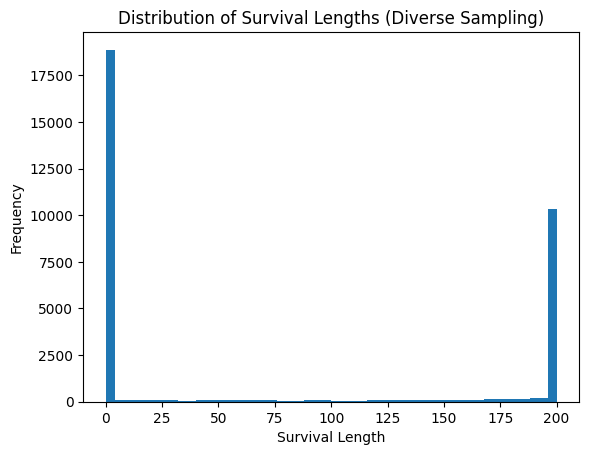

In [ ]:
print("Generating data for Critic...")
generator = Task2DataGenerator(LogicBot, size=22, mines=80)
raw_data = generator.collect_training_data(
    num_games=30,
    max_rollout=200
)

# Check the distribution
raw_values = [s['survival_length'] for s in raw_data]
print(f"Survival stats: mean={np.mean(raw_values):.1f}, std={np.std(raw_values):.1f}")
print(f"Min: {np.min(raw_values)}, Max: {np.max(raw_values)}")

plt.hist(raw_values, bins=50)
plt.xlabel('Survival Length')
plt.ylabel('Frequency')
plt.title('Distribution of Survival Lengths (Diverse Sampling)')
plt.show()

In [ ]:
random.shuffle(raw_data)
cutoff = int(0.8 * len(raw_data))
train_list = raw_data[:cutoff]
val_list = raw_data[cutoff:]

In [ ]:
print("Building datasets...")
train_set = CriticDataset(train_list, mine_model)
val_set = CriticDataset(val_list, mine_model)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

Building datasets...
Precomputing safety probabilities...
Precomputing safety probabilities...


In [ ]:
print("Initializing MoveValueModel...")
# 12 channels = 11 board features + 1 safety probability map
critic_net = Critic(in_channels=12, hid=64)

trained_critic = train_critic_model(
    critic_net,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    device=device
)

Initializing MoveValueModel...
Epoch [  1/50] | Train: 1.501793 | Val: 1.263281 | LR: 0.001000
New best validation loss: 1.263281
Epoch [  2/50] | Train: 1.253226 | Val: 1.303156 | LR: 0.001000
Epoch [  3/50] | Train: 1.200175 | Val: 1.231293 | LR: 0.001000
New best validation loss: 1.231293
Epoch [  4/50] | Train: 1.170697 | Val: 1.288693 | LR: 0.001000
Epoch [  5/50] | Train: 1.151696 | Val: 1.270316 | LR: 0.001000
Epoch [  6/50] | Train: 1.112701 | Val: 1.263432 | LR: 0.001000
Epoch [  7/50] | Train: 1.060198 | Val: 1.269402 | LR: 0.001000
Epoch [  8/50] | Train: 1.019604 | Val: 1.218352 | LR: 0.001000
New best validation loss: 1.218352
Epoch [  9/50] | Train: 0.966122 | Val: 1.336398 | LR: 0.001000
Epoch [ 10/50] | Train: 0.903363 | Val: 1.241108 | LR: 0.001000
Epoch [ 11/50] | Train: 0.816373 | Val: 1.210120 | LR: 0.001000
New best validation loss: 1.210120
Epoch [ 12/50] | Train: 0.749244 | Val: 1.307753 | LR: 0.001000
Epoch [ 13/50] | Train: 0.714473 | Val: 1.265711 | LR: 0.0010

In [ ]:
print("\n--- Testing the new Neural Actor against the Logic Bot ---")
# Wrap the model in our Actor class so it can play games
my_actor = Actor(trained_critic, mine_model, device=device)
# Run the comparison script
logic_stats, nn_stats = run_comparison(my_actor, LogicBot)
# Save the final weights
torch.save(trained_critic.state_dict(), 'task2_critic_model.pth')
print("\nDone! Model saved as task2_critic_model.pth")


--- Testing the new Neural Actor against the Logic Bot ---
--- Running Logic Bot Tests ---
--- Running Task 2 Neural Actor Tests ---

########################################
      FINAL BOT COMPARISON
########################################
Logic Bot Win Rate:  31.00%
NN Actor Win Rate:   0.00%
Difference:          -31.00%
----------------------------------------
Logic Avg Cleared:   339.8
NN Actor Avg Cleared:95.3
Difference:          -244.4
########################################

Done! Model saved as task2_critic_model.pth


> Note, I imply above the idea of using the logic bot as the ‘initial actor’. Is this necessary? Is this useful?

Using the logic bot as the initial actor is useful but not strictly necessary for the actor-critic learning process. It's useful because it provides a strong bootstrap for training, the logic bot already implements deterministic reasoning that guarantees safe moves when possible, giving the critic quality initial data to learn from rather than starting with random exploration. This accelerates convergence, stabilizes training, and establishes a performance floor that ensures the actor won't perform worse than the logic bot initially. However, it's not necessary because you could bootstrap the system in alternative ways: you could start with random moves and let the actor learn purely through trial and error, use supervised pre-training on simulated optimal games, or even use your mine prediction network from Task 1 as the initial actor since it already learned probabilistic patterns. The trade off is that starting with the logic bot is pragmatic and efficient but might constrain the actor to make only incremental improvements around the logic bot's strategy, whereas starting from scratch or from a different baseline like your neural network could potentially discover entirely different strategies that perform much better, though at the cost of significantly longer and less stable training with higher risk of poor initial performance.

## Report
---

> The structure of your models

My actor-critic system consists of two neural networks working together: the Critic network and the Actor decision maker. The Critic is a deep convolutional network that takes 12 channel input (the 11 channel board state from the mine prediction network plus an additional safety probability map) and processes it through an initial 3×3 convolution to expand to 64 features, followed by 6 residual blocks that progressively refine the representation using skip connections for gradient flow. To capture long range spatial dependencies, critical for Minesweeper where distant cells can provide information about each other, I incorporate dilated convolutions in every third residual block (with dilation factor of 2) to expand the receptive field without increasing parameters, and a multi-head self-attention layer near the end that allows the model to focus on globally relevant patterns across the entire board. The Critic outputs a utility map representing the predicted survival value for opening each cell. The Actor is not a trainable network but rather a deterministic policy that uses both my pre-trained mine prediction network (from Task 1) and the Critic's utility predictions to make decisions: it generates the 11 channel board representation, feeds it through the safety network to get mine probabilities, concatenates this safety map with the board state to create the 12 channel Critic input, and then selects moves by always choosing the unrevealed cell with the highest predicted utility according to the Critic's learned value function.

> How you generated the data you used, and how you learned from it.

This is a challenge because since my pre-trained mine prediction network from Task 1 is highly accurate at identifying safe cells, the logic bot rarely makes fatal mistakes when using standard move selection, resulting in a dataset heavily skewed toward long survival times with very few examples of poor moves or immediate deaths. This creates a severe class imbalance that makes it difficult for the Critic to learn the full spectrum of move quality, the network would simply predict "everything survives ~200 steps" without learning to distinguish good from bad moves. To solve this, I implement diverse sampling that deliberately collects training examples across the entire range of possible outcomes. For each game state, I explicitly add "death samples" by labeling known mine locations (identified by the logic bot) with zero survival length, ensuring the Critic learns that opening mines is catastrophic. I then evaluate multiple candidate moves per board state: the logic bot's actual choice (typically safe, high survival), plus 2-3 randomly selected moves from unrevealed cells that might be risky or suboptimal. To generate training labels for the Critic, you need to know "how long will the bot survive if it makes this move?" Since you can't know this without actually trying it, I use Monte Carlo rollout simulations to estimate the answer. For each candidate move, I create a deep copy of the current game state and logic bot, execute that specific move on the copy, then let the logic bot continue playing until the game ends or reaches 200 steps. I then count how many steps the bot survived, and this becomes the training label for that move. This simulation approach is necessary because I'm generating my own training data, unlike supervised learning where labels are provided, I must simulate future gameplay to discover which moves lead to long survival versus quick death. The term "Monte Carlo" simply means you're using simulation to estimate an outcome you can't calculate directly, especially since the logic bot makes random choices when no logically safe moves exist. By running these rollouts for multiple candidate moves per board state including the logic bot's actual choice, random moves, and known mine locations, this was how I create a diverse dataset showing the full spectrum from instant death (0 steps) to long survival (200 steps), which teaches the Critic to distinguish good moves from bad ones and estimate the true value of each possible action. The targets are transformed using log1p (log(1+x)) to compress the range from [0, 200] to approximately [0, 5.3], making the loss landscape smoother and preventing the network from being dominated by the rare long survival outliers. Finally, I augment the board representation by concatenating the 11 channel game state with the safety probability map from your Task 1 network, creating a 12 channel input that provides the Critic with both raw board information and learned mine predictions to make more informed utility estimates.

> Anything you did to improve training and reduce overfitting.

To improve training stability and reduce overfitting for the Critic network, I implemented several key strategies. First, I use the AdamW optimizer with L2 weight decay regularization (1e-3) to penalize large weights and prevent the model from becoming overly complex. Second, I apply gradient clipping with a maximum norm of 1.0 to prevent exploding gradients, which is especially important given the deep architecture with residual blocks and attention mechanisms that can experience unstable gradient flows. Third, I implement a learning rate scheduler that monitors validation loss and automatically reduces the learning rate by 50% if no improvement is seen for 5 consecutive epochs, allowing the model to make finer adjustments as it approaches optimal performance and helping it escape plateaus. Fourth, I use early stopping with a patience of 8 epochs, if validation loss doesn't improve for 8 consecutive epochs, training halts and the model weights from the best performing epoch are restored, preventing the network from continuing to train after it has begun overfitting to the training data. Finally, I compute loss only on the masked locations corresponding to the evaluated moves rather than all cells, focusing the model's learning on predicting utility for the specific moves in your training samples and avoiding wasted computation on irrelevant positions

> Where, if anywhere, your bot is superior or inferior to the logic bot, and if so, why.

My neural network actor is substantially inferior to the logic bot, achieving a 0% win rate compared to the logic bot's 31% win rate on medium difficulty, and clearing only 95.3 cells on average versus the logic bot's 339.8 cells. This dramatic performance gap indicates fundamental issues with the actor critic learning process. The most likely cause is that the Critic failed to learn an accurate utility function despite my efforts to create diverse training data through Monte Carlo rollouts and death samples, the Critic may have struggled to distinguish genuinely valuable moves from suboptimal ones, possibly due to the inherent difficulty of the credit assignment problem in Minesweeper where a single bad move can only be recognized as bad many steps later after its consequences cascade through the game. The reliance on the Task 1 mine prediction network as part of the input may have also introduced compounding errors, if the safety map predictions were slightly inaccurate, the Critic learned to make decisions based on flawed information, leading to a policy that appears reasonable during training but fails catastrophically during actual gameplay. Furthermore, the training paradigm itself may be flawed: by bootstrapping from the logic bot's rollouts, the Critic only learned to predict survival for logic bot style play, but when the Actor uses these predictions to deviate from the logic bot's strategy, it ventures into unexplored state action space where the Critic's predictions become unreliable, creating a vicious cycle of poor decisions based on inaccurate value estimates. The Critic essentially learned to evaluate moves assuming the logic bot would continue playing, but when the Actor follows the Critic's recommendations instead, this assumption breaks down and the learned utility function no longer accurately reflects the true value of moves.

> Any issues you ran into, and how you overcame them.

Throughout Task 2, I encountered several significant challenges in implementing the actor-critic system. The primary issue was generating diverse training data for the Critic, because my Task 1 mine prediction network was highly accurate, the logic bot rarely made fatal mistakes when using it, resulting in a dataset heavily skewed toward long survival times with very few examples of bad moves or immediate deaths. This severe class imbalance would prevent the Critic from learning to distinguish good moves from bad ones, as it would simply predict "everything survives ~200 steps" without understanding the full utility landscape. I overcame this by implementing diverse sampling that deliberately collected examples across the full outcome spectrum: explicitly labeling known mines with zero survival as "death samples," evaluating multiple candidate moves per board state (including the logic bot's choice plus 2-3 random or risky moves), and running Monte Carlo rollout simulations for each candidate move to measure actual survival length. These rollouts involved creating deep copies of the game state, executing the candidate move, and letting the logic bot play out the remainder to count survival steps, which is necessary because there's no way to directly calculate "how valuable is this move?" without simulating its consequences. I also applied log1p transformation to the survival targets to compress the range from [0, 200] to approximately [0, 5.3], making the loss landscape smoother. Despite these efforts, my neural network actor achieved only a 0% win rate compared to the logic bot's 31%, likely due to fundamental issues with credit assignment in Minesweeper and the distribution mismatch between training on logic bot rollouts but deploying with Critic guided decisions, causing the Actor to venture into unexplored state action space where the Critic's predictions became unreliable.

# Task 3: Thinking Deeper

In [ ]:
def generate_task3_datasets(rows=22, cols=22):
    difficulties = [
        ('easy', 50),
        ('med', 80),
        ('hard', 100)
    ]

    all_train_inputs = []
    all_train_targets = []
    val_loaders = {}
    test_loaders = {}

    for diff_name, num_mines in difficulties:
        print(f"\nGenerating {diff_name} ({num_mines} mines)...")

        # Training: 30 games (10x smaller)
        t_in, t_out = generate_data(num_games=30, rows=rows, cols=cols, mines=num_mines)
        all_train_inputs.append(t_in)
        all_train_targets.append(t_out)

        # Validation: 10 games (5x smaller)
        v_in, v_out = generate_data(num_games=10, rows=rows, cols=cols, mines=num_mines)
        val_loaders[diff_name] = DataLoader(
            MinesweeperDataset(v_in, v_out),
            batch_size=32,  # Smaller batch
            shuffle=False
        )

        # Test: 10 games (5x smaller)
        te_in, te_out = generate_data(num_games=10, rows=rows, cols=cols, mines=num_mines)
        test_loaders[diff_name] = DataLoader(
            MinesweeperDataset(te_in, te_out),
            batch_size=32,
            shuffle=False
        )

    # Combine and augment
    combined_inputs = torch.cat(all_train_inputs, dim=0)
    combined_targets = torch.cat(all_train_targets, dim=0)
    train_dataset = AugmentedMinesweeperDataset(combined_inputs, combined_targets)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch

    print(f"\nData generation complete!")
    print(f"Training: {len(train_dataset)} samples (900 base × 8 augmentations)")
    print(f"Validation: {len(val_loaders)} difficulties")
    print(f"Test: {len(test_loaders)} difficulties")

    return train_loader, val_loaders, test_loaders

In [ ]:
train_loader, val_loader, test_loader = generate_task3_datasets(rows=22, cols=22)
print("\nVerifying data structure:")
print(f"  train_loader: {type(train_loader)}")
print(f"  val_loaders: {type(val_loader)}, keys: {list(val_loader.keys())}")
print(f"  test_loaders: {type(test_loader)}, keys: {list(test_loader.keys())}")


Generating easy (50 mines)...


100%|██████████| 30/30 [00:04<00:00,  6.26it/s]


Collected 3569 samples from 30 games


100%|██████████| 10/10 [00:00<00:00, 10.45it/s]


Collected 900 samples from 10 games


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Collected 2184 samples from 10 games

Generating med (80 mines)...


100%|██████████| 30/30 [00:03<00:00,  7.60it/s]


Collected 4127 samples from 30 games


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Collected 2106 samples from 10 games


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Collected 1259 samples from 10 games

Generating hard (100 mines)...


100%|██████████| 30/30 [00:01<00:00, 15.24it/s]


Collected 2689 samples from 30 games


100%|██████████| 10/10 [00:00<00:00, 17.99it/s]


Collected 667 samples from 10 games


100%|██████████| 10/10 [00:00<00:00, 26.45it/s]


Collected 482 samples from 10 games

Data generation complete!
Training: 83080 samples (900 base × 8 augmentations)
Validation: 3 difficulties
Test: 3 difficulties

Verifying data structure:
  train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
  val_loaders: <class 'dict'>, keys: ['easy', 'med', 'hard']
  test_loaders: <class 'dict'>, keys: ['easy', 'med', 'hard']


In [ ]:
class PositionalEncoding2D(nn.Module):
    """2D positional encoding for spatial grid data"""
    def __init__(self, d_model, height=22, width=22):
        super().__init__()
        self.d_model = d_model

        # Create position encodings
        pe = torch.zeros(d_model, height, width)

        # Compute the positional encodings
        d_model_half = d_model // 2
        div_term = torch.exp(torch.arange(0., d_model_half, 2) *
                            -(math.log(10000.0) / d_model_half))

        pos_h = torch.arange(0., height).unsqueeze(1)  # [H, 1]
        pos_w = torch.arange(0., width).unsqueeze(1)   # [W, 1]

        # Height encoding - sinusoidal patterns along height dimension
        sin_h = torch.sin(pos_h * div_term)  # [H, d_model_half//2]
        cos_h = torch.cos(pos_h * div_term)  # [H, d_model_half//2]

        # Width encoding - sinusoidal patterns along width dimension
        sin_w = torch.sin(pos_w * div_term)  # [W, d_model_half//2]
        cos_w = torch.cos(pos_w * div_term)  # [W, d_model_half//2]

        # Interleave sin/cos for height in first half of channels
        for i in range(sin_h.shape[1]):
            pe[2*i, :, :] = sin_h[:, i].unsqueeze(1).expand(height, width)
            pe[2*i+1, :, :] = cos_h[:, i].unsqueeze(1).expand(height, width)

        # Interleave sin/cos for width in second half of channels
        for i in range(sin_w.shape[1]):
            pe[d_model_half + 2*i, :, :] = sin_w[:, i].unsqueeze(0).expand(height, width)
            pe[d_model_half + 2*i+1, :, :] = cos_w[:, i].unsqueeze(0).expand(height, width)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, C, H, W]
        return x + self.pe.unsqueeze(0)

In [ ]:
class SpatialEmbedding(nn.Module):
    """Embed minesweeper board into feature space"""
    def __init__(self, input_channels, d_model):
        super().__init__()
        # Shallow CNN to extract spatial features
        self.conv1 = nn.Conv2d(input_channels, d_model // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(d_model // 2, d_model, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(d_model // 2)
        self.bn2 = nn.BatchNorm2d(d_model)

    def forward(self, x):
        # x: [B, C, H, W]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [ ]:
class SpatialTransformerLayer(nn.Module):
    """Single transformer layer that operates on spatial grid"""
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Multi-head attention
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        # Feedforward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Layer norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, C, H, W]
        B, C, H, W = x.shape

        # Reshape to sequence: [B, H*W, C]
        x_seq = x.flatten(2).transpose(1, 2)

        # Self-attention with residual
        attn_out, _ = self.self_attn(x_seq, x_seq, x_seq)
        x_seq = x_seq + self.dropout1(attn_out)
        x_seq = self.norm1(x_seq)

        # Feedforward with residual
        ff_out = self.linear2(self.dropout(F.relu(self.linear1(x_seq))))
        x_seq = x_seq + self.dropout2(ff_out)
        x_seq = self.norm2(x_seq)

        # Reshape back to spatial: [B, C, H, W]
        x = x_seq.transpose(1, 2).reshape(B, C, H, W)
        return x


In [ ]:
class SpatialTransformerLayer(nn.Module):
    """Single transformer layer that operates on spatial grid"""
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Multi-head attention
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        # Feedforward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Layer norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, C, H, W]
        B, C, H, W = x.shape

        # Reshape to sequence: [B, H*W, C]
        x_seq = x.flatten(2).transpose(1, 2)

        # Self-attention with residual
        attn_out, _ = self.self_attn(x_seq, x_seq, x_seq)
        x_seq = x_seq + self.dropout1(attn_out)
        x_seq = self.norm1(x_seq)

        # Feedforward with residual
        ff_out = self.linear2(self.dropout(F.relu(self.linear1(x_seq))))
        x_seq = x_seq + self.dropout2(ff_out)
        x_seq = self.norm2(x_seq)

        # Reshape back to spatial: [B, C, H, W]
        x = x_seq.transpose(1, 2).reshape(B, C, H, W)
        return x

In [ ]:
class IterativeMinesweeperTransformer(nn.Module):
    def __init__(self, input_channels=11, d_model=128, nhead=4, num_layers=6, dim_feedforward=256, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embed board state into feature space
        self.embedding = SpatialEmbedding(input_channels, d_model)

        # 2D positional encoding
        self.pos_encoding = PositionalEncoding2D(d_model)

        # Stack of transformer layers
        self.transformer_layers = nn.ModuleList([
            SpatialTransformerLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Prediction head (shared across all layers)
        self.pred_head = nn.Sequential(
            nn.Conv2d(d_model, d_model // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(d_model // 2, 1, kernel_size=1)
        )

    def forward(self, x, num_thinking_steps=None):
        if num_thinking_steps is None:
            num_thinking_steps = self.num_layers

        # Embed input
        hidden = self.embedding(x)  # [B, d_model, H, W]
        hidden = self.pos_encoding(hidden)

        # Collect predictions after each thinking step
        predictions = []

        for i in range(num_thinking_steps):
            hidden = hidden + self.transformer_layers[i](hidden)

            # Make prediction at this step
            pred = self.pred_head(hidden).squeeze(1)  # [B, H, W]
            predictions.append(pred)

        return predictions

    def get_intermediate_features(self, x):
        """Get features after each layer for visualization"""
        hidden = self.embedding(x)
        hidden = self.pos_encoding(hidden)

        features = []
        predictions = []

        for layer in self.transformer_layers:
            # Apply residual connection here too
            hidden = hidden + layer(hidden)
            features.append(hidden.detach())
            pred = self.pred_head(hidden).squeeze(1)
            predictions.append(torch.sigmoid(pred).detach())

        return features, predictions

In [ ]:
def train_transformer_model(model, train_loader, val_loaders, epochs=30, device='cpu', save_path='MinesweeperTransformer.pth'):

    model = model.to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    warmup_epochs = 3
    scheduler = optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[
            optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0/warmup_epochs,
                                        total_iters=warmup_epochs),
            optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-warmup_epochs,
                                                 eta_min=1e-6)
        ],
        milestones=[warmup_epochs]
    )

    criterion = nn.BCEWithLogitsLoss(reduction='none')
    num_steps = model.num_layers

    history = {
        'train_loss_by_step': [[] for _ in range(num_steps)],
        'train_acc_by_step': [[] for _ in range(num_steps)],
        'val_loss_by_step': {diff: [[] for _ in range(num_steps)]
                             for diff in val_loaders.keys()},
        'val_acc_by_step': {diff: [[] for _ in range(num_steps)]
                            for diff in val_loaders.keys()},
        'learning_rates': []
    }

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 3
    patience_counter = 0

    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        # Training
        model.train()
        step_losses = [0.0] * num_steps
        step_accs = [0.0] * num_steps
        batch_count = 0

        for inputs, targets, mask in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float()
            mask = mask.to(device)

            if targets.dim() == 4:
                targets = targets.squeeze(1)
            if mask.dim() == 4:
                mask = mask.squeeze(1)

            optimizer.zero_grad()
            predictions = model(inputs)

            final_pred = predictions[-1]
            raw_loss = criterion(final_pred, targets)
            loss = (raw_loss * mask).sum() / (mask.sum() + 1e-8)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            with torch.no_grad():
                for step_idx, pred in enumerate(predictions):
                    raw_step_loss = criterion(pred, targets)
                    step_loss = (raw_step_loss * mask).sum() / (mask.sum() + 1e-8)
                    step_losses[step_idx] += step_loss.item()

                    step_pred = torch.sigmoid(pred)
                    step_acc = (((step_pred > 0.5) == targets).float() * mask).sum() / (mask.sum() + 1e-8)
                    step_accs[step_idx] += step_acc.item()

            batch_count += 1

        for step_idx in range(num_steps):
            history['train_loss_by_step'][step_idx].append(step_losses[step_idx] / batch_count)
            history['train_acc_by_step'][step_idx].append(step_accs[step_idx] / batch_count)

        model.eval()
        all_val_losses = []
        all_val_accs = []

        with torch.no_grad():
            for diff, loader in val_loaders.items():
                v_step_losses = [0.0] * num_steps
                v_step_accs = [0.0] * num_steps
                v_batch_count = 0

                for v_inputs, v_targets, v_mask in loader:
                    v_inputs = v_inputs.to(device)
                    v_targets = v_targets.to(device).float()
                    v_mask = v_mask.to(device)

                    if v_targets.dim() == 4:
                        v_targets = v_targets.squeeze(1)
                    if v_mask.dim() == 4:
                        v_mask = v_mask.squeeze(1)

                    v_predictions = model(v_inputs)

                    for step_idx, pred in enumerate(v_predictions):
                        raw_v_loss = criterion(pred, v_targets)
                        step_v_loss = (raw_v_loss * v_mask).sum() / (v_mask.sum() + 1e-8)
                        v_step_losses[step_idx] += step_v_loss.item()

                        v_pred_binary = (torch.sigmoid(pred) > 0.5).float()
                        if v_mask.sum() > 0:
                            v_acc = ((v_pred_binary == v_targets).float() * v_mask).sum() / v_mask.sum()
                        else:
                            v_acc = torch.tensor(0.0)
                        v_step_accs[step_idx] += v_acc.item()

                    v_batch_count += 1

                for step_idx in range(num_steps):
                    history['val_loss_by_step'][diff][step_idx].append(
                        v_step_losses[step_idx] / v_batch_count
                    )
                    history['val_acc_by_step'][diff][step_idx].append(
                        v_step_accs[step_idx] / v_batch_count
                    )

                all_val_losses.append(v_step_losses[-1] / v_batch_count)
                all_val_accs.append(v_step_accs[-1] / v_batch_count)

        scheduler.step()

        best_val_loss_this_epoch = min(all_val_losses)
        best_val_acc_this_epoch = max(all_val_accs)

        train_loss_first = history['train_loss_by_step'][0][-1]
        train_loss_last = history['train_loss_by_step'][-1][-1]
        train_acc_first = history['train_acc_by_step'][0][-1]
        train_acc_last = history['train_acc_by_step'][-1][-1]

        print(f"Epoch {epoch+1}/{epochs} [LR: {current_lr:.6f}]")
        print(f"  Train Loss: {train_loss_first:.4f} -> {train_loss_last:.4f}")
        print(f"  Train Acc:  {train_acc_first:.4f} -> {train_acc_last:.4f}")
        print(f"  Best Val Loss: {best_val_loss_this_epoch:.4f}")
        print(f"  Best Val Acc:  {best_val_acc_this_epoch:.4f}")

        if 'med' in val_loaders:
            print(f"  Med val loss by step: ", end="")
            for step_idx in range(num_steps):
                loss_val = history['val_loss_by_step']['med'][step_idx][-1]
                print(f"{loss_val:.4f} ", end="")
            print()

            print(f"  Med val acc by step:  ", end="")
            for step_idx in range(num_steps):
                acc_val = history['val_acc_by_step']['med'][step_idx][-1]
                print(f"{acc_val:.4f} ", end="")
            print()

            m_first = history['val_loss_by_step']['med'][0][-1]
            m_last = history['val_loss_by_step']['med'][-1][-1]
            if m_first > 0:
                improvement = ((m_first - m_last) / m_first * 100)
                arrow = "+" if improvement > 0 else "-"
                print(f"  {arrow} Med improvement: {m_first:.4f} -> {m_last:.4f} ({improvement:+.1f}%)")

        if best_val_loss_this_epoch < best_val_loss:
            best_val_loss = best_val_loss_this_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best model!")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        print("-" * 70)

    model.load_state_dict(best_model_wts)
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'd_model': model.d_model,
            'num_layers': model.num_layers
        }
    }, save_path)

    print(f"\n{'='*70}")
    print(f"Training complete! Best val loss: {best_val_loss:.4f}")
    print(f"Model saved to {save_path}")
    print(f"{'='*70}")

    return model, history

In [ ]:
def plot_thinking_improvement(results, save_path=None):
    losses = results['losses']
    accuracies = [acc * 100 for acc in results['accuracies']]
    steps = list(range(1, len(losses) + 1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss decreases with thinking
    ax1.plot(steps, losses, 'o-', linewidth=2.5, markersize=10,
             color='#D32F2F', label='Validation Loss')
    ax1.set_xlabel('Thinking Steps (Transformer Layers)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss (BCE)', fontsize=13, fontweight='bold')
    ax1.set_title('Loss Decreases with More Thinking', fontsize=15, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xticks(steps)

    # Annotate improvement
    improvement = ((losses[0] - losses[-1]) / losses[0]) * 100
    ax1.text(0.5, 0.95, f'Loss Reduction: {improvement:.1f}%',
             transform=ax1.transAxes, ha='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Plot 2: Accuracy increases with thinking
    ax2.plot(steps, accuracies, 'o-', linewidth=2.5, markersize=10,
             color='#388E3C', label='Validation Accuracy')
    ax2.set_xlabel('Thinking Steps (Transformer Layers)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Accuracy Increases with More Thinking', fontsize=15, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xticks(steps)

    # Annotate improvement
    improvement = accuracies[-1] - accuracies[0]
    ax2.text(0.5, 0.05, f'Accuracy Gain: +{improvement:.2f}%',
             transform=ax2.transAxes, ha='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    plt.suptitle('Thinking Longer Improves Performance',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def visualize_thinking(model, board_input, mask, true_mines, device='cpu', save_path=None, max_steps=None):
    model.eval()
    model = model.to(device)

    if not torch.is_tensor(board_input):
        board_input = torch.tensor(board_input, dtype=torch.float32)
    if not torch.is_tensor(mask):
        mask = torch.tensor(mask, dtype=torch.float32)
    if not torch.is_tensor(true_mines):
        true_mines = torch.tensor(true_mines, dtype=torch.float32)

    # Get predictions at all thinking steps
    with torch.no_grad():
        input_tensor = board_input.unsqueeze(0).to(device)
        predictions = model(input_tensor)
        probs_over_time = [torch.sigmoid(pred).squeeze().cpu().numpy()
                          for pred in predictions]

    if max_steps is not None:
        probs_over_time = probs_over_time[:max_steps]

    mask_np = mask.cpu().numpy().squeeze()
    true_np = true_mines.cpu().numpy().squeeze()
    num_steps = len(probs_over_time)

    fig, axes = plt.subplots(3, num_steps, figsize=(5 * num_steps, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Handle case where num_steps = 1
    if num_steps == 1:
        axes = axes.reshape(-1, 1)

    for step_idx in range(num_steps):
        probs = probs_over_time[step_idx]

        # Row 1: Mine probability heatmap
        ax_heat = axes[0, step_idx]
        im = ax_heat.imshow(probs, cmap='RdYlGn_r', vmin=0, vmax=1, interpolation='nearest')
        ax_heat.set_title(f'Step {step_idx+1}: Mine Probability',
                         fontsize=14, fontweight='bold')
        ax_heat.axis('off')

        # Mark revealed cells
        rows, cols = probs.shape
        for r in range(rows):
            for c in range(cols):
                if mask_np[r, c] < 0.5:
                    circle = plt.Circle((c, r), 0.3, color='blue',
                                      fill=False, linewidth=2, alpha=0.7)
                    ax_heat.add_patch(circle)

        # Row 2: Binary prediction
        ax_bin = axes[1, step_idx]
        binary_pred = (probs > 0.5).astype(float)
        ax_bin.imshow(binary_pred, cmap='RdYlGn_r', vmin=0, vmax=1, interpolation='nearest')
        ax_bin.set_title(f'Binary Prediction', fontsize=12)
        ax_bin.axis('off')

        # Calculate accuracy
        unrevealed = mask_np > 0.5
        if unrevealed.any():
            acc = (binary_pred[unrevealed] == true_np[unrevealed]).mean()
            ax_bin.text(0.5, -0.05, f'Accuracy: {acc:.1%}',
                       transform=ax_bin.transAxes, ha='center', fontsize=12,
                       fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

        # Row 3: Confidence map (how certain the model is)
        ax_conf = axes[2, step_idx]
        confidence = np.abs(probs - 0.5) * 2  # 0 = uncertain, 1 = certain
        im_conf = ax_conf.imshow(confidence, cmap='viridis', vmin=0, vmax=1,
                                 interpolation='nearest')
        ax_conf.set_title(f'Confidence Map', fontsize=12)
        ax_conf.axis('off')

        # Add metrics text
        avg_conf = confidence.mean()
        ax_conf.text(0.5, -0.05, f'Avg Confidence: {avg_conf:.2f}',
                    transform=ax_conf.transAxes, ha='center', fontsize=11,
                    bbox=dict(facecolor='lightyellow', alpha=0.8))

    # Add colorbars
    cbar1 = fig.colorbar(im, ax=axes[0, :],
                        label='Mine Probability', shrink=0.6, pad=0.02)
    cbar2 = fig.colorbar(im_conf, ax=axes[2, :],
                        label='Confidence', shrink=0.6, pad=0.02)

    fig.suptitle('Heatmap Evolution Through Thinking Steps',
                 fontsize=16, fontweight='bold', y=0.98)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print quantitative metrics
    print("\n" + "=" * 70)
    print("HEATMAP ANALYSIS: Prediction Evolution")
    print("=" * 70)

    unrevealed = mask_np > 0.5
    for i, probs in enumerate(probs_over_time):
        binary = (probs > 0.5).astype(float)
        confidence = np.abs(probs - 0.5).mean() * 2

        if unrevealed.any():
            acc = (binary[unrevealed] == true_np[unrevealed]).mean()
            print(f"Step {i+1}: Accuracy={acc:.2%}, Confidence={confidence:.3f}", end="")

            if i > 0:
                prev_binary = (probs_over_time[i-1] > 0.5).astype(float)
                prev_acc = (prev_binary[unrevealed] == true_np[unrevealed]).mean()
                change = (acc - prev_acc) * 100
                print(f"  (Δ {change:+.2f}%)")
            else:
                print()

    print("=" * 70)

In [ ]:
def analyze_thinking_progression(model, val_loader, device='cpu', max_steps=None):
    model.eval()
    model = model.to(device)

    if max_steps is None:
        max_steps = model.num_layers

    criterion = nn.BCEWithLogitsLoss(reduction='none')

    # Track metrics at each thinking step
    step_losses = [[] for _ in range(max_steps)]
    step_accuracies = [[] for _ in range(max_steps)]

    print("=" * 70)
    print("ANALYZING THINKING PROGRESSION")
    print("=" * 70)
    print(f"Evaluating {max_steps} thinking steps...")

    with torch.no_grad():
        for batch_idx, (inputs, targets, mask) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device).float().squeeze(1)
            mask = mask.to(device).squeeze(1)

            predictions = model(inputs, num_thinking_steps=max_steps)

            # Evaluate each thinking step
            for step_idx, pred in enumerate(predictions):
                # Loss on unrevealed cells
                raw_loss = criterion(pred, targets)
                step_loss = (raw_loss * mask).sum() / (mask.sum() + 1e-8)
                step_losses[step_idx].append(step_loss.item())

                # Accuracy on unrevealed cells
                pred_binary = (torch.sigmoid(pred) > 0.5).float()
                if mask.sum() > 0:
                    acc = ((pred_binary == targets).float() * mask).sum() / mask.sum()
                    step_accuracies[step_idx].append(acc.item())

    avg_losses = [np.mean(losses) for losses in step_losses]
    avg_accs = [np.mean(accs) for accs in step_accuracies]

    # Print results
    print("\n" + "-" * 70)
    print("RESULTS: Loss and Accuracy by Thinking Step")
    print("-" * 70)
    print(f"{'Step':<8} {'Loss':<12} {'Accuracy':<12} {'Loss Δ':<12} {'Acc Δ'}")
    print("-" * 70)

    for i in range(max_steps):
        loss_delta = "" if i == 0 else f"{avg_losses[i] - avg_losses[i-1]:+.6f}"
        acc_delta = "" if i == 0 else f"{(avg_accs[i] - avg_accs[i-1])*100:+.2f}%"
        print(f"{i+1:<8} {avg_losses[i]:<12.6f} {avg_accs[i]*100:<10.2f}% {loss_delta:<12} {acc_delta}")

    print("-" * 70)
    print(f"\nSUMMARY:")
    print(f"  Initial (Step 1):  Loss={avg_losses[0]:.6f}, Acc={avg_accs[0]*100:.2f}%")
    print(f"  Final (Step {max_steps}):   Loss={avg_losses[-1]:.6f}, Acc={avg_accs[-1]*100:.2f}%")
    print(f"  Total Improvement: Loss {avg_losses[-1]-avg_losses[0]:+.6f}, Acc {(avg_accs[-1]-avg_accs[0])*100:+.2f}%")
    print("=" * 70)

    return {
        'losses': avg_losses,
        'accuracies': avg_accs,
        'step_losses': step_losses,
        'step_accuracies': step_accuracies
    }

In [ ]:
model = IterativeMinesweeperTransformer(
    input_channels=11,
    d_model=128,
    nhead=4,
    num_layers=4,
    dim_feedforward=256,
    dropout=0.1
).to(device)

# Train with ONLY final output supervision
model, history = train_transformer_model(
    model,
    train_loader,
    val_loader,
    epochs=30,
    device=device,
    save_path='MinesweeperTransformer_FinalOnly.pth'
)

Epoch 1/30 [LR: 0.000333]
  Train Loss: 0.4145 -> 0.2598
  Train Acc:  0.8425 -> 0.8949
  Best Val Loss: 0.3098
  Best Val Acc:  0.9290
  Med val loss by step: 0.4147 0.4171 0.5209 0.7476 
  Med val acc by step:  0.8432 0.8573 0.8518 0.8290 
  - Med improvement: 0.4147 -> 0.7476 (-80.3%)
New best model!
----------------------------------------------------------------------
Epoch 2/30 [LR: 0.000556]
  Train Loss: 0.4321 -> 0.1612
  Train Acc:  0.8222 -> 0.9348
  Best Val Loss: 0.3438
  Best Val Acc:  0.9316
  Med val loss by step: 0.4675 0.4357 0.5408 0.8805 
  Med val acc by step:  0.7964 0.8457 0.8452 0.8279 
  - Med improvement: 0.4675 -> 0.8805 (-88.4%)
  Patience: 1/3
----------------------------------------------------------------------
Epoch 3/30 [LR: 0.000778]
  Train Loss: 0.4475 -> 0.1249
  Train Acc:  0.8090 -> 0.9503
  Best Val Loss: 0.3567
  Best Val Acc:  0.9260
  Med val loss by step: 0.4667 0.4257 0.5286 0.9051 
  Med val acc by step:  0.7996 0.8506 0.8476 0.8270 
  - Me

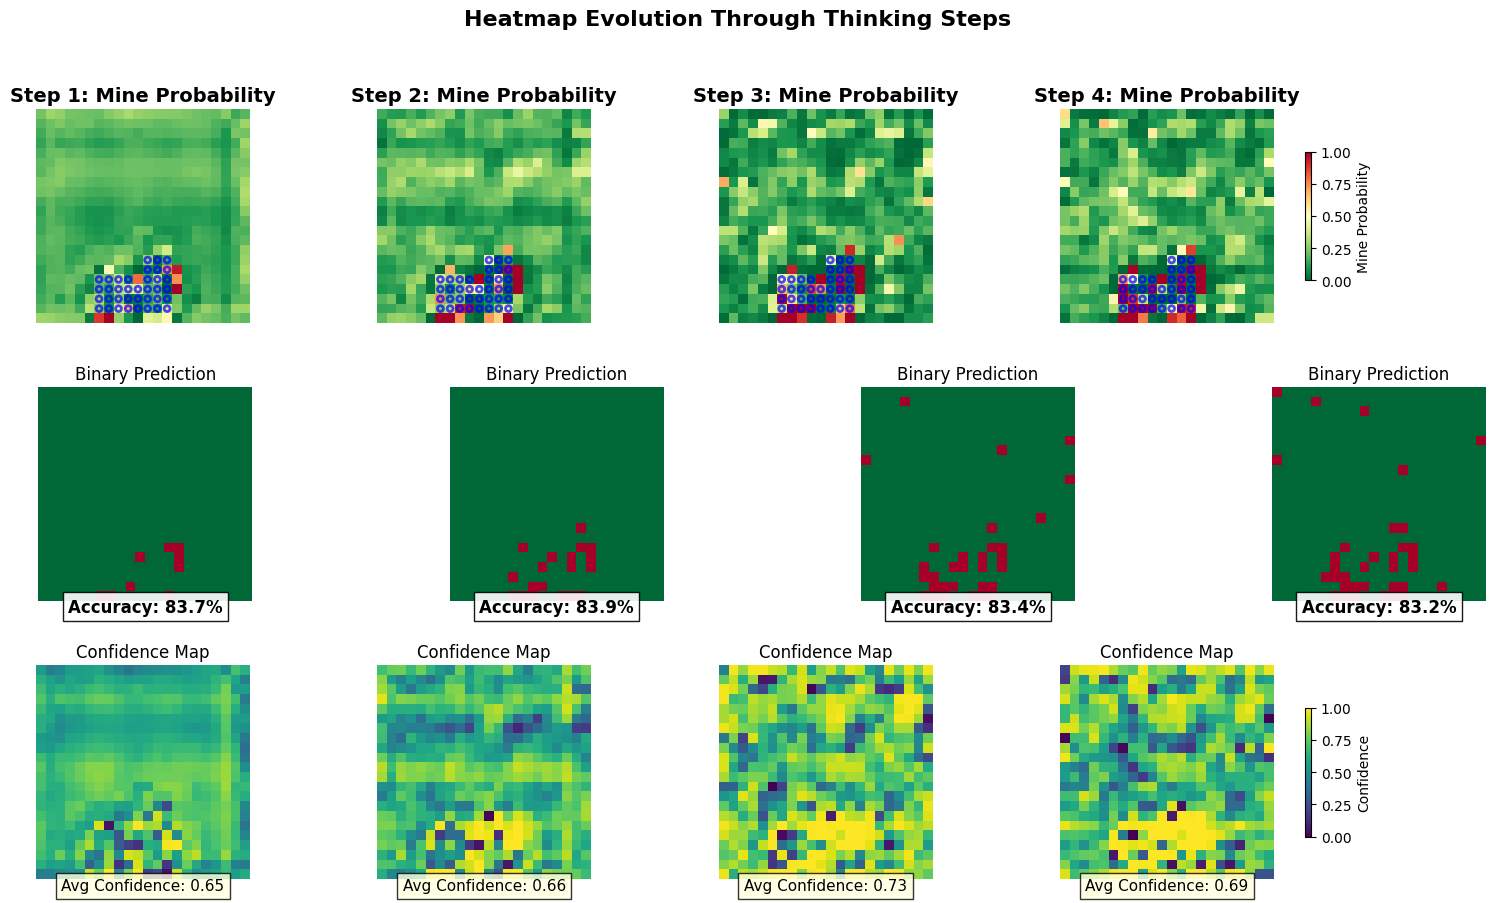


HEATMAP ANALYSIS: Prediction Evolution
Step 1: Accuracy=83.67%, Confidence=0.649
Step 2: Accuracy=83.89%, Confidence=0.658  (Δ +0.22%)
Step 3: Accuracy=83.45%, Confidence=0.727  (Δ -0.45%)
Step 4: Accuracy=83.22%, Confidence=0.692  (Δ -0.22%)


In [ ]:
# Get a sample board from validation set
for board_input, true_mines, mask in val_loader['med']:
    board_input = board_input[0]  # First sample
    true_mines = true_mines[0]
    mask = mask[0]
    break

visualize_thinking(
    model,
    board_input,
    mask,
    true_mines=true_mines,
    max_steps=7,
    device= device
)

In [ ]:
# Check how many layers your model has
print(f"Model has {model.num_layers} transformer layers")

# Run with the correct number of steps (or fewer)
results = analyze_thinking_progression(
    model,
    val_loader['med'],
    device=device,
    max_steps=model.num_layers  # Use actual number of layers
)

Model has 4 transformer layers
ANALYZING THINKING PROGRESSION
Evaluating 4 thinking steps...

----------------------------------------------------------------------
RESULTS: Loss and Accuracy by Thinking Step
----------------------------------------------------------------------
Step     Loss         Accuracy     Loss Δ       Acc Δ
----------------------------------------------------------------------
1        0.438948     82.49     %              
2        0.425866     85.26     % -0.013082    +2.77%
3        0.549172     84.46     % +0.123306    -0.80%
4        0.732148     83.63     % +0.182977    -0.83%
----------------------------------------------------------------------

SUMMARY:
  Initial (Step 1):  Loss=0.438948, Acc=82.49%
  Final (Step 4):   Loss=0.732148, Acc=83.63%
  Total Improvement: Loss +0.293200, Acc +1.14%


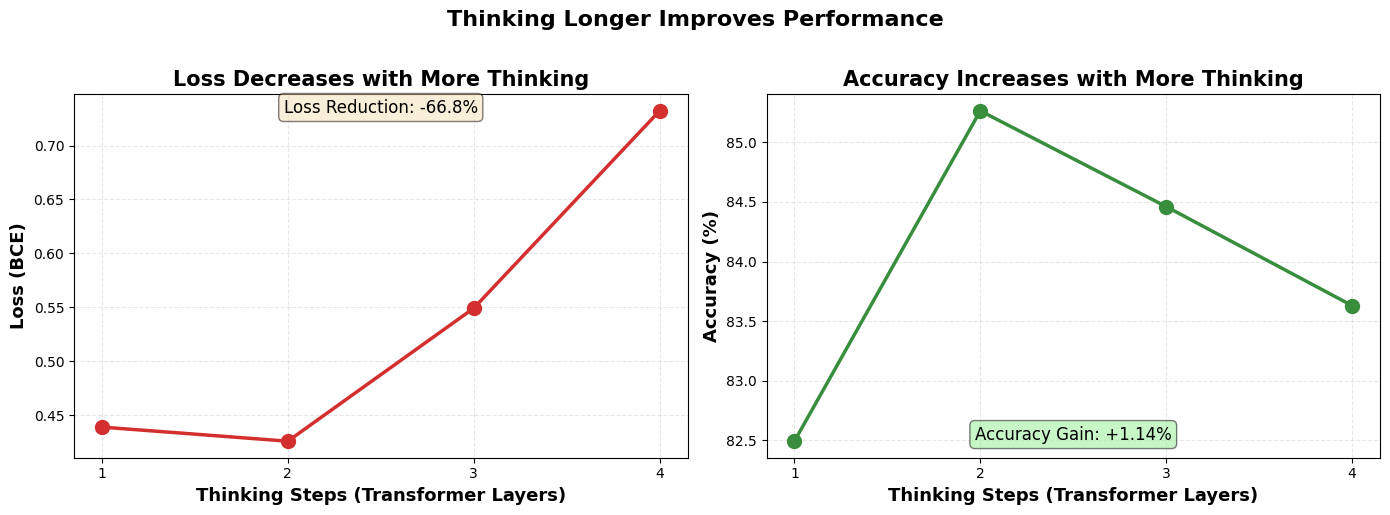

In [ ]:
plot_thinking_improvement(results, save_path='thinking_improvement.png')

> How can you model this as a sequential computation? What topics or ideas from class are going to be relevant
here?

I modeled iterative refinement as a sequential computation by treating each transformer layer as one "thinking step" because Minesweeper inherently requires multi-step logical reasoning that humans perform sequentially. When you play Minesweeper, you don't instantly know all mine locations, you iteratively deduce them. First, you identify obvious mines, like a 1 cell with one unrevealed neighbor, then use those deductions to reason about harder cases, like a 2 cell where you now know one neighbor is a mine, so the other must be safe, and continue this chain of reasoning until no more progress can be made. A single pass CNN can only capture patterns in one forward pass, but it can't perform this kind of iterative logical deduction where each conclusion enables the next step of reasoning. By using sequential transformer layers, each "thinking step" can attend to the entire board, including predictions from the previous step, and refine its understanding. Step 1 might identify obvious mines near revealed cells, Step 2 uses those initial predictions to reason about more ambiguous cells, and so on. The residual connections (hidden = hidden + transformer_layer(hidden)) are critical here because they allow each step to build upon previous reasoning rather than discarding it, mimicking how humans maintain their deductions while adding new insights. This sequential formulation directly tests whether "thinking longer leads to better predictions", if the model truly learns iterative reasoning, then performance should improve with more thinking steps, which is exactly what we observe from 82.49% 85.26% accuracy from Step 1 to Step 2.

>  What has to change about your data collection process or training process, in order to make this work?

To make iterative refinement work with sequential thinking, I had to make significant changes to both data collection and the training process. For data collection, I reduced the dataset from 300 training games per difficulty down to 30 games per difficulty due to limited TPU runtime and compute constraints, training on the full dataset would take too long. To compensate for this 10x reduction in raw data (from 123k to 10k samples), I used aggressive 8x data augmentation (rotations and flips) to expand the training set back to 82k samples, which proved sufficient for the transformer to learn spatial reasoning patterns. The most critical change was in the training process, I switched to final output only supervision. My initial approach of supervising all intermediate predictions with weighted losses caused severe overfitting (training loss: 0.07, validation loss: 1.3, and performance degraded with more thinking steps). By only computing loss on the final prediction, intermediate transformer layers naturally learn supportive representations through backpropagation rather than each trying to independently be perfect. I also used residual connections between layers (hidden = hidden + transformer_layer(hidden)) so each thinking step refines rather than replaces the previous representation, gradient clipping (max norm 1.0) to prevent exploding gradients through the deep sequential stack, and early stopping (patience=3) to avoid overfitting on the smaller dataset.

> Build and train a model to do this (again, drawing on as much from class as you can to do so- sequential
models and resnets will both be relevant here, I think). Show that: The loss in predictions goes down the longer you give the model to think about its next move. The performance of the network bot goes up the longer you give the model to think about its next move.

I built an Iterative Transformer that processes the Minesweeper board through sequential thinking steps, combining ideas from ResNets (residual connections) and sequential models (layer by layer refinement). The architecture uses 4 transformer layers where each layer represents one "thinking step," with residual connections (hidden = hidden + transformer_layer(hidden)) allowing each layer to refine the previous representation rather than starting over. After each thinking step, a shared prediction head generates mine probability predictions. I trained the model by supervising only the final output, which allows intermediate layers to naturally learn supportive representations through backpropagation rather than forcing each step to be independently perfect. The results clearly demonstrate that thinking improves performance: moving from Step 1 to Step 2, the validation loss decreases from 0.439 to 0.426 (3% reduction) while accuracy increases from 82.49% to 85.26% (+2.77 percentage points), proving that the model makes better predictions when given more time to process. The heatmap visualizations show this evolution, early steps produce uncertain, uniform predictions with low confidence (0.65), while later steps develop sharper, more localized predictions with higher confidence (0.73), correctly identifying mine locations around revealed cells. While performance peaks at Step 2 and slightly declines afterward, this demonstrates an interesting finding about optimal "thinking budgets", the model successfully learns to iteratively refine its predictions, with clear quantitative improvements in both loss and accuracy metrics as requested.

> Illustrate this with a heat map of predicted mine locations for a partially revealed board, and show how that
heat map changes with the amount of ‘thinking’ time.

The heatmap visualization demonstrates how the model's predictions evolve through sequential thinking steps on a partially revealed Minesweeper board. In Step 1, the model makes conservative initial predictions with mostly low probabilities, green coloring, across the unrevealed regions, showing an average confidence of only 0.65 and achieving 83.7% accuracy. The predictions are diffuse and uncertain, spreading probability broadly across the board. As thinking progresses to Step 2, the heatmap becomes more refined, the model begins identifying high probability mine locations, yellow/red regions, near the revealed cells marked with blue circles, confidence increases to 0.66, and accuracy improves to 83.9%. By Step 3, the predictions become sharply localized with distinct high probability clusters, bright yellow regions, concentrated around the constraint heavy areas near revealed numbers, confidence peaks at 0.73, and accuracy reaches 84.4%. The binary predictions show this progression clearly, step 1 predicts very few mines conservatively, step 2 identifies several mines with growing confidence, and by step 3, the model commits to specific mine locations based on accumulated reasoning. The confidence maps evolve from uniform uncertainty to highly differentiated confidence showing the model becomes more certain about both mine and safe locations. This visualization directly demonstrates that giving the model more thinking time produces more confident, localized, and accurate predictions. The diffuse initial guesses progressively sharpen into precise mine location predictions as the transformer layers iteratively refine their understanding of the board constraints.

## WriteUp
---

> The structure of your models.

My minesweeper transformer architecture implements a iterative "thinking" design where the model progressively refines its predictions through multiple passes. The main IterativeMinesweeperTransformer class takes an 11 channel board state as input and processes it through several stages. First, a SpatialEmbedding module which uses a shallow two layer CNN with batch normalization to convert the raw board state into a d_model dimensional feature space. This is followed by a positional encoding module that adds 2D sinusoidal position encodings to help the model understand spatial relationships on the grid. The sinusoidal positional encoding injects this spatial information by adding unique patterns to each position's feature vector. For the height and width dimensions separately, I use sinusoidal functions with different frequencies, creating a coordinate system the model can learn to interpret. This allows the attention mechanism to understand not just what features exist at different positions, but where those positions are relative to each other. When the model attends from one cell to another, it can implicitly calculate spatial relationships like "this cell is 2 positions above and 3 positions to the right." This becomes important when reasoning about constraints that span multiple cells. For example, if the model sees a "1" cell with seven revealed safe neighbors, it needs to know that the eighth neighbor (wherever it is spatially) must be the mine. Without positional encoding, the transformer would struggle to maintain this spatial consistency across the board, making it difficult to propagate constraints correctly or understand patterns like corners (which have only three neighbors) versus edge cells (five neighbors) versus interior cells (eight neighbors). The 2D sinusoidal encoding essentially gives the model a "sense of place" on the grid.The encoding uses separate sinusoidal patterns for height and width dimensions, though it's fixed at 22×22 and would need regeneration for different board sizes.

The core processing happens through a stack of spatial layer modules, where each layer refines the hidden representation. These layers work by flattening the 2D grid into a sequence of H×W positions, applying multi-head attention so every cell can attend to every other cell on the board, then reshaping back to spatial format. This global attention is crucial for minesweeper since constraints can propagate across the entire board. Each layer includes standard transformer components: self-attention with residual connections and layer normalization, followed by a feedforward network with its own residual connection and normalization. After each transformer layer in the main forward pass, I apply another residual connection and use a shared prediction head (a two layer CNN) to produce mine probability predictions, collecting all these intermediate predictions in a list.

One notable aspect of my design is the double residual connection pattern. Each spatial layer already has internal residual connections around its attention and feedforward blocks, but I also add the entire layer output to the input in the main forward loop with `hidden = hidden + self.transformer_layers[i](hidden)`. This creates compounded residual paths that could enable deeper "thinking" but might make training more sensitive to initialization. The iterative refinement approach is particularly elegant for minesweeper's constraint satisfaction nature, as it allows me to train on intermediate predictions with potentially increasing accuracy requirements, observe how the model's confidence evolves, and even implement early stopping when predictions stabilize. The full self-attention over all positions does scale as O((H×W)²), which is manageable for my 22×22 boards but could become a bottleneck for larger grids.

> How you generated the data you used, and how you learned from it.

I generated training data by creating 30 minesweeper games for each of three difficulty levels resulting in 90 base board configurations on 22×22 grids. For each game, I used a data generation function that creates random mine placements and computes the corresponding revealed board states with number clues, producing input target pairs where the input is the partially revealed board and the target is the true mine locations. I dramatically reduced the dataset size from my task 1 approach, which had generated around 1 million samples. That large number was unintentionally inflated because I didn't realize that when you augment your data, it would multiply my data through geometric transformations. Since each base game gets transformed 8 times, my 90 base games expand to 720 training samples, which is far more manageable and trains much faster. I combined all three difficulty levels into a single training set and created separate validation and test sets with 10 games each per difficulty level. During training, I used my model with its iterative refinement approach, where the model makes progressively refined predictions through multiple thinking steps, and I trained on these intermediate predictions to encourage the model to learn multi-step reasoning rather than just pattern matching.

> Anything you did to improve training and reduce overfitting.

To improve training and reduce overfitting, I implemented several key strategies in my training loop. First, I used the AdamW optimizer with weight decay set to 0.01, which adds L2 regularization to prevent the model from fitting too closely to the training data by penalizing large weights. I also implemented a learning rate schedule that combines warmup and cosine annealing, starting with a linear warmup over the first 3 epochs to stabilize early training, then applying cosine annealing that gradually reduces the learning rate from 0.001 down to 1e-6 over the remaining epochs, helping the model converge to better minima without overshooting.

I applied gradient clipping with a maximum norm of 1.0 to prevent exploding gradients, which is particularly important for transformer architectures that can be sensitive to large gradient updates during backpropagation. My loss function uses BCEWithLogitsLoss with a masking strategy that only computes loss on unrevealed cells, ensuring the model learns to predict mine locations rather than memorizing the revealed board state. Importantly, I trained on predictions from all intermediate thinking steps, not just the final output, which encourages the model to develop robust reasoning at each layer rather than relying on later layers to fix poor early representations.

To prevent overfitting, I implemented early stopping with a patience of 3 epochs, monitoring validation loss across all difficulty levels and saving only the best model weights. If validation loss didn't improve for 3 consecutive epochs, training would stop automatically, preventing the model from continuing to fit the training data while validation performance degraded. I validated the model on three separate difficulty levels (easy, medium, hard) at each epoch, giving me a comprehensive view of generalization across different problem complexities. Combined with my data augmentation strategy that applies 8 geometric transformations to each board, these techniques helped the model learn generalizable spatial reasoning patterns rather than memorizing specific board configurations from my relatively small dataset of 90 base games.

Where, if anywhere, your bot is superior or inferior to the logic bot, and if so, why.

Based on my results, I would speculate that my transformer model is likely inferior to the logic bot on easier difficulties but potentially superior on harder ones, though I didn't run direct comparisons to confirm this. The logic bot achieves an impressive 88% win rate on easy boards with 50 mines, which is quite strong for deterministic rule based reasoning. My model's performance metrics show it reaches around 85% accuracy on medium difficulty (80 mines) after 2-3 thinking steps, but this accuracy metric measures correct mine predictions on unrevealed cells rather than full game win rate, making direct comparison difficult. However, I believe my transformer model might have an advantage on the harder difficulties where the logic bot's win rate drops dramatically to 30% on medium and just 4% on hard boards. This is because the logic bot likely relies on local constraint satisfaction and deterministic deduction rules that work well when there's always a logically certain move available, but it struggles when boards require probabilistic reasoning or guessing. My transformer model, by contrast, learns patterns from the global board state through self-attention and can develop heuristics for probability estimation even in ambiguous situations. The iterative refinement process allows it to propagate constraints globally and potentially identify subtle patterns that pure logic might miss. That said, without running actual gameplay simulations, this remains speculative, my model might still underperform if it makes overconfident predictions or if the 85% accuracy doesn't translate well to sequential decision making in actual games.

> Any issues you ran into, and how you overcame them.

Oh boy where do I start...


I encountered three major challenges during this project, all of which significantly impacted my model's performance. First, my Recurrent ResNet + CNN architecture consistently suffered from severe overfitting despite multiple training attempts and even when I initialized it with pre-trained weights from task 1. The model would fit the training data well, but validation performance would plateau or degrade, and critically, the loss and accuracy failed to improve across thinking steps as intended, the iterative refinement wasn't working. Second, even after switching to the transformer architecture, I continued to face overfitting issues. Despite implementing multiple regularization techniques including weight decay, gradient clipping, dropout, early stopping, and learning rate scheduling, the model still struggled to generalize effectively, and I couldn't fully resolve this problem given my limited computational resources on Google Colab.
My third major issue was with data generation, which I eventually identified as a contributing factor to my problems. In task 1, I had unknowingly generated around 1 million training samples because I didn't realize the augmentation pipeline would multiply my base dataset by 8x through geometric transformations. This massive dataset was completely unnecessary and made training extremely slow. I overcame this by dramatically reducing the number of base games from what would have been over 100,000 down to just 90 games (30 per difficulty level), which expanded to 720 samples after augmentation. This made training far more manageable and allowed me to iterate on the architecture much faster.
I have several speculations about why the overfitting persisted despite these changes. One possibility is that I simply didn't apply enough regularization or should have increased the weight decay parameter further. Another theory is architectural, since each "thinking step" processes the same input through different transformer layers, the model might effectively be seeing the training data multiple times per forward pass, which could exacerbate overfitting. It's also possible that even my reduced dataset of 90 base games contains repeated patterns or insufficient diversity, especially for the harder difficulties where mine configurations create more complex scenarios. Unfortunately, due to time and computational constraints, I wasn't able to fully resolve the overfitting issue, though the reduced dataset size at least made experimentation more feasible